<a href="https://www.kaggle.com/code/brmil07/bank-stock-price-forecasting?scriptVersionId=166616866" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Bank Stock Price Forecasting 💹**
---
This dataset contains historical stock price data for major banks from the year 2014 to 2024. The dataset includes daily stock prices, trading volume, and other relevant financial metrics for prominent banks. The stock prices are provided in IDR (Indonesian Rupiah) currency.

# **Preparation Phase 🧺**
---
## **Install the Libraries 📚**
---

In [1]:
# Install the scalecast library at the begininng
!pip install scalecast --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.9 MB/s eta 0:00:00
  Created wheel for scalecast: filename=SCALECAST-0.19.8-py3-none-any.whl size=125274 sha256=c0051a47ea948f5d401e2b268aaca8b03ef5c5b5cb88f8fafb4cff8c03077311
  Stored in directory: /root/.cache/pip/wheels/ac/67/2e/0244bcec7f41d76aae4c4196b64d31a20d474a7d5468f3d67e
Successfully built scalecast
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uni

## **Import the Libraries 🏪**
---

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-stock-price/Bank_Stock_Price_10Y.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scalecast.Forecaster import Forecaster

from sklearn.linear_model import Lasso, SGDRegressor, Ridge, LinearRegression
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

## **Load the dataset 🗄️**
---

In [4]:
df = pd.read_csv('/kaggle/input/bank-stock-price/Bank_Stock_Price_10Y.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2483 entries, 0 to 2482
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2483 non-null   object 
 1   Open       2483 non-null   float64
 2   High       2483 non-null   float64
 3   Low        2483 non-null   float64
 4   Close      2483 non-null   float64
 5   Adj Close  2483 non-null   float64
 6   Volume     2483 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 135.9+ KB


In [6]:
df.head().style.background_gradient(cmap='cividis')

In [7]:
# Check for missing values
df.isna().sum()

# Locate NaN values in the 'Price' column
# nan_rows = df[df['Volume'].isna()]
# print(nan_rows)

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
df1 = df[['Date','Adj Close']].copy(deep=True)
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date',inplace = True)
df1.rename(columns={'Adj Close': 'Price'}, inplace=True)
df1 = df1.resample('W').mean()
df1.ffill(inplace=True)

In [9]:
df1[:10].style.background_gradient(cmap='viridis')

In [10]:
# Check for missing values
df1.isna().sum()

Price    0
dtype: int64

# **Exploratory Data Analysis 🔍**
---

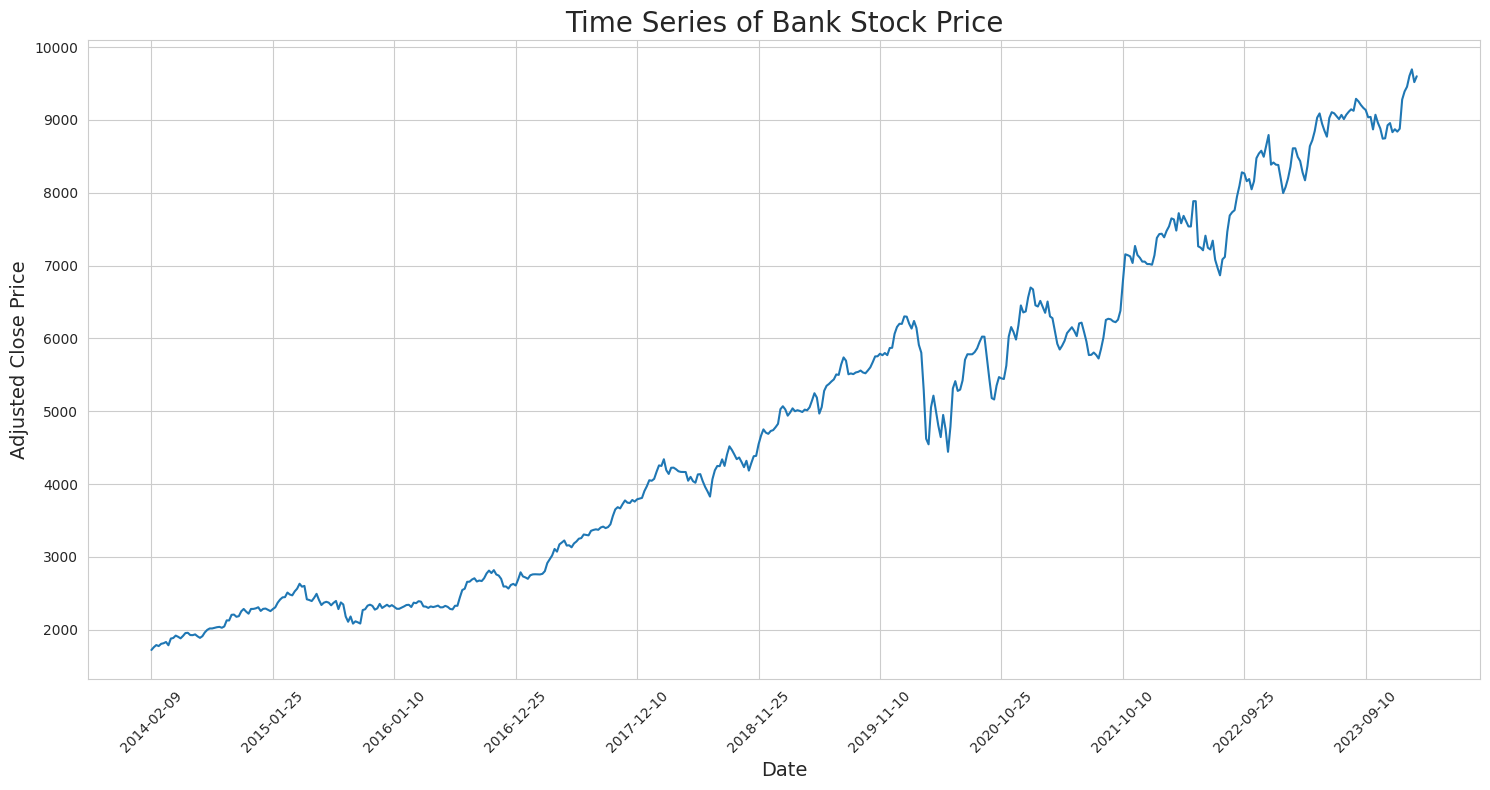

In [11]:
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
ax=sns.lineplot(data=df1, x=df1.index, y='Price')

# Set x-axis ticks for every 50th data point
n = 50  
plt.xticks(df1.index[::n])

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.title("Time Series of Bank Stock Price", fontsize=20)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Adjusted Close Price", fontsize=14)
plt.tight_layout()
plt.show()

# **Stationarity Test 🧪**
---

In [12]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,8), facecolor='lightgrey')
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [13]:
def tsplot(y, lags=None, figsize=(15, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize, facecolor='lightgrey')
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

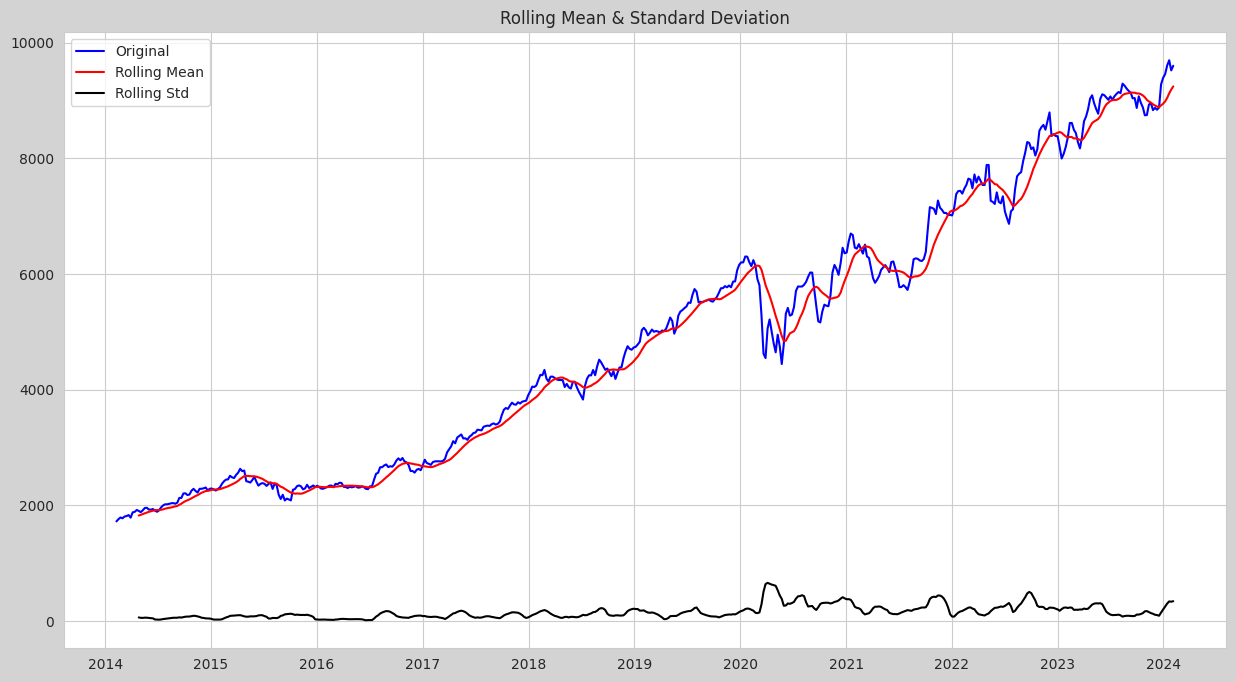

Results of Dickey-Fuller Test:
Test Statistic                   1.025763
p-value                          0.994530
#Lags Used                      17.000000
Number of Observations Used    504.000000
Critical Value (1%)             -3.443392
Critical Value (5%)             -2.867292
Critical Value (10%)            -2.569833
dtype: float64


In [14]:
test_stationarity(df1['Price'])

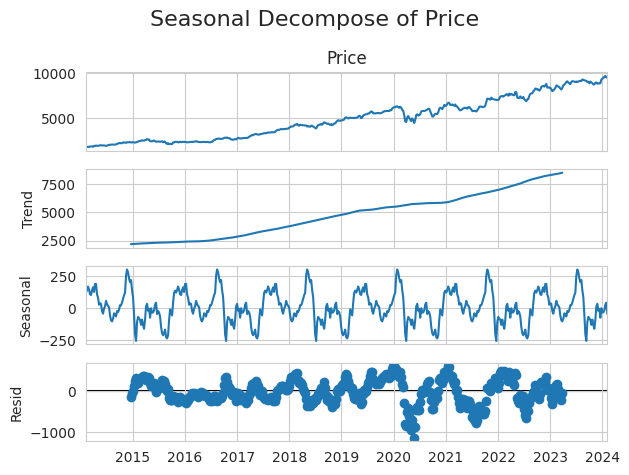

In [15]:
dec = sm.tsa.seasonal_decompose(df1['Price'], period=90).plot()

plt.suptitle('Seasonal Decompose of Price', fontsize=16)
plt.tight_layout()
plt.show()

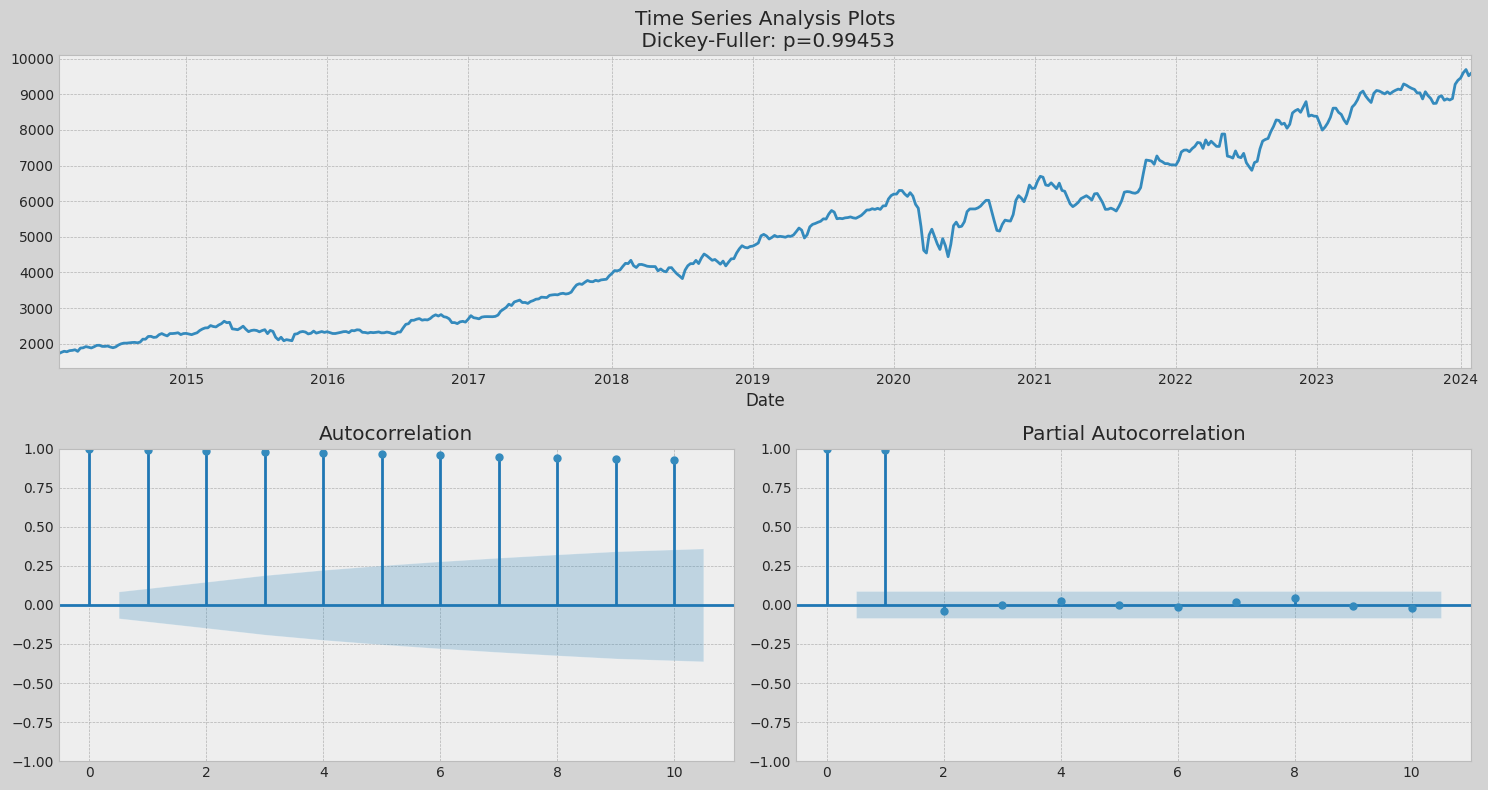

In [16]:
tsplot(df1['Price'], lags = 10)

A **p-value** of **0.9944530** from Dickey-Fuller Test indicates that the data is likely not stationary. For time series forecasting with stock price data, it is crucial to make the data stationary before feeding it into a machine learning model. 

Here are some common techniques to make time series data stationary:

* **Differencing**: Take the difference between consecutive observations. This can help remove trends or seasonality.
* **Transformation**: Apply transformations such as logarithmic transformation to stabilize the variance.
* **Detrending**: Remove a linear trend from the data.
* **Seasonal Adjustment**: Remove seasonal components from the data using techniques like seasonal decomposition.
* **Rolling Statistics**: Use moving averages or rolling standard deviations to stabilize variations in the data.

# **Data Transformation 🔨**
---

In [17]:
df2 = df1.copy()
df2.head().style.background_gradient(cmap='cividis')

## **Method 1: Differencing 📏**
---

In [18]:
# Take the first difference
df2['Price_Diff'] = df2['Price'].diff()
df2.head().style.background_gradient(cmap='cividis')

## **Method 2: Logarithmic Transformation 🪜**
---

In [19]:
df2['Price_Log'] = np.log(df2['Price'])
df2.head().style.background_gradient(cmap='cividis')

## **Method 3: Detrending 📉**
---

In [20]:
# Calculate the rolling mean
rolling_mean = df2['Price'].rolling(window=30).mean()

df2['Price_Detrended'] = df2['Price'] - rolling_mean  # Adjust the window size as needed
df2.head().style.background_gradient(cmap='cividis')

/opt/conda/lib/python3.10/site-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/opt/conda/lib/python3.10/site-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


## **Method 4: Seasonal Decompose ⚙️**
---

In [21]:
result_sd = seasonal_decompose(df2['Price'], model='additive', period=52)  # Assuming weekly seasonality, adjust period accordingly
df2['Price_Seasonal_Adjusted'] = df2['Price'] - result_sd.seasonal
df2.head().style.background_gradient(cmap='cividis')

/opt/conda/lib/python3.10/site-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/opt/conda/lib/python3.10/site-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


## **Method 5: Rolling Statistics 🎢**
---

In [22]:
window_size = 30  # Adjust the window size as needed
df2['Price_Rolling_Mean'] = df2['Price'].rolling(window=window_size).mean()
df2['Price_Rolling_Std'] = df2['Price'].rolling(window=window_size).std()
df2.head().style.background_gradient(cmap='cividis')

/opt/conda/lib/python3.10/site-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/opt/conda/lib/python3.10/site-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


## **Test the Stationarity of Transformed Data 🎡**
---

In [23]:
df2.isna().sum()

Price                       0
Price_Diff                  1
Price_Log                   0
Price_Detrended            29
Price_Seasonal_Adjusted     0
Price_Rolling_Mean         29
Price_Rolling_Std          29
dtype: int64

In [24]:
# Drop NaN values introduced by data transformation
df2.dropna(inplace=True)
df2.head().style.background_gradient(cmap='cividis')

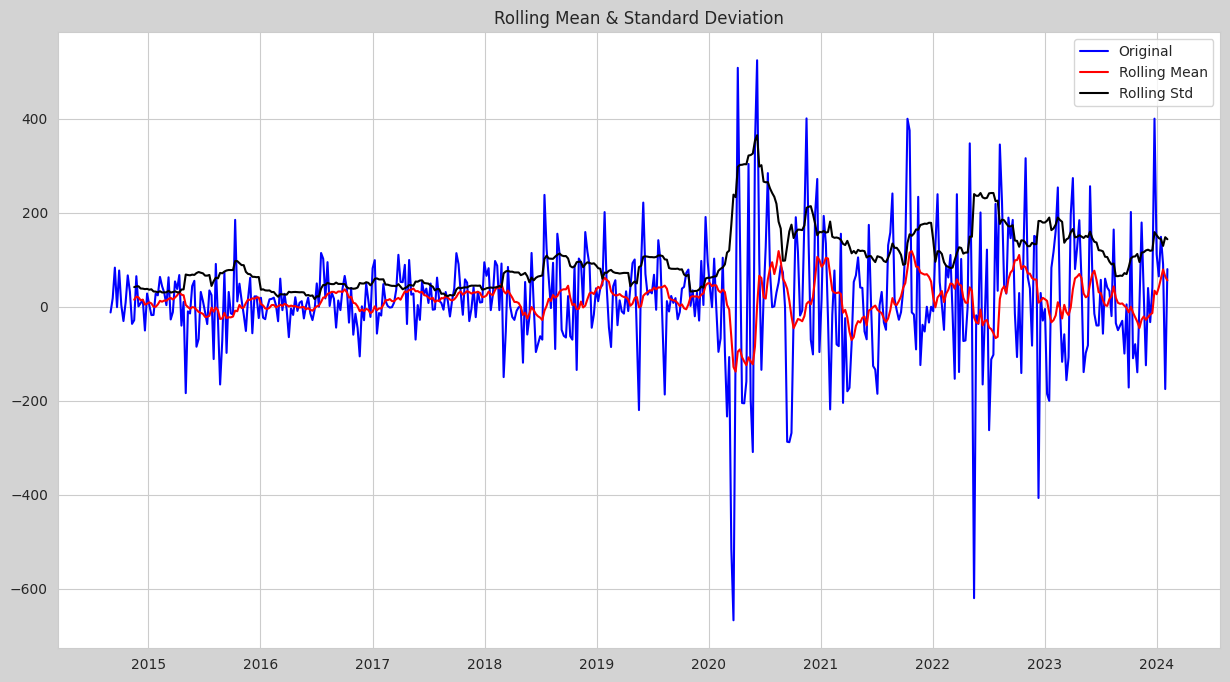

Results of Dickey-Fuller Test:
Test Statistic                -7.753459e+00
p-value                        9.878975e-12
#Lags Used                     1.600000e+01
Number of Observations Used    4.760000e+02
Critical Value (1%)           -3.444163e+00
Critical Value (5%)           -2.867631e+00
Critical Value (10%)          -2.570014e+00
dtype: float64


In [25]:
test_stationarity(df2['Price_Diff'])

A **p-value** of **2.508131e-12** from the Dickey-Fuller test strongly suggests that the differenced data is stationary. In statistical hypothesis testing, a p-value below a significance level (commonly 0.05) indicates strong evidence against the null hypothesis, which in this case would be that the data is non-stationary.

Given the extremely low p-value obtained, it's reasonable to conclude that the differenced data is stationary and suitable for use in a model. Utilizing this transformed data can be proceeded for time series modeling and forecasting.

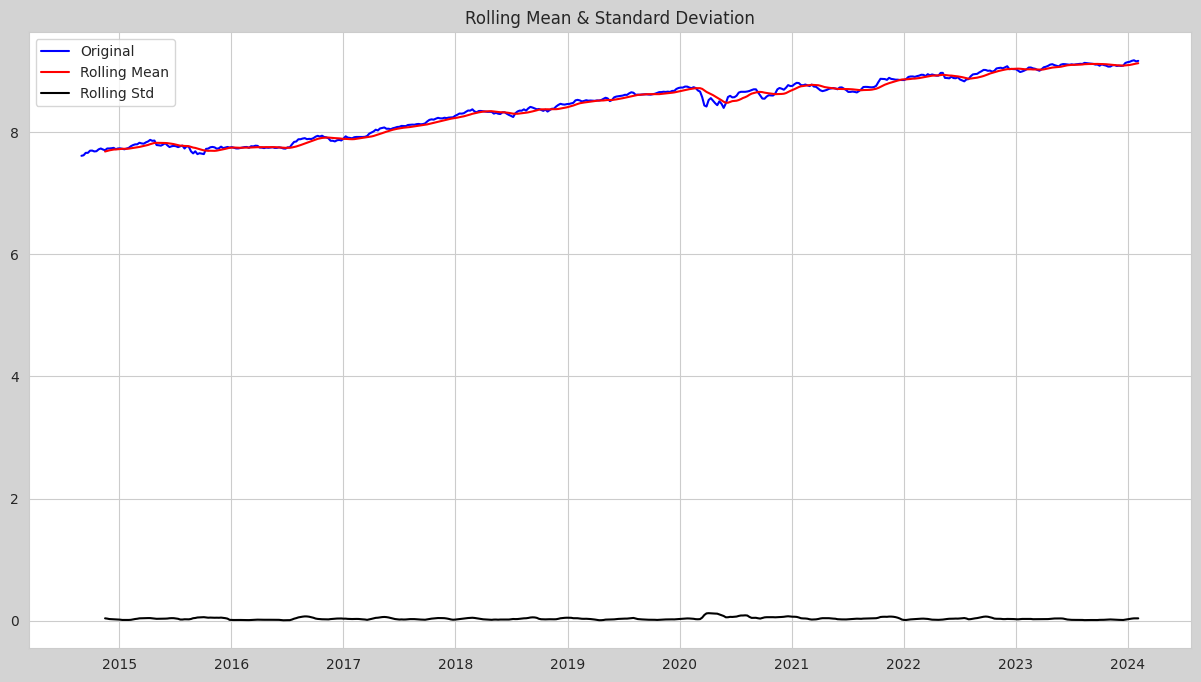

Results of Dickey-Fuller Test:
Test Statistic                  -0.616359
p-value                          0.867243
#Lags Used                       2.000000
Number of Observations Used    490.000000
Critical Value (1%)             -3.443766
Critical Value (5%)             -2.867457
Critical Value (10%)            -2.569921
dtype: float64


In [26]:
test_stationarity(df2['Price_Log'])

A **p-value** of **0.867243** from the Dickey-Fuller test strongly suggests that the differenced data is still not stationary. Let's explore the next data transformation methods.

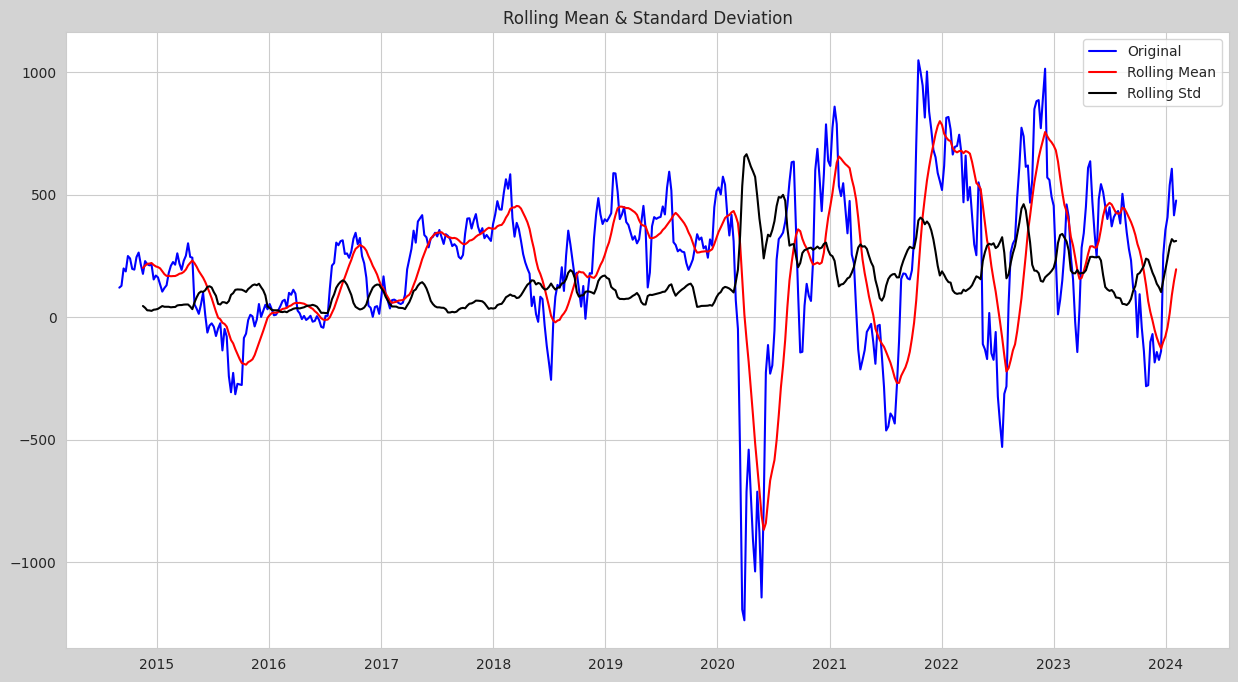

Results of Dickey-Fuller Test:
Test Statistic                -6.140943e+00
p-value                        7.974300e-08
#Lags Used                     9.000000e+00
Number of Observations Used    4.830000e+02
Critical Value (1%)           -3.443962e+00
Critical Value (5%)           -2.867543e+00
Critical Value (10%)          -2.569967e+00
dtype: float64


In [27]:
test_stationarity(df2['Price_Detrended'])

A **p-value** of **7.974300e-08** from the Dickey-Fuller test strongly suggests that the differenced data is stationary. This might be one of the candidate to feed in the model later.

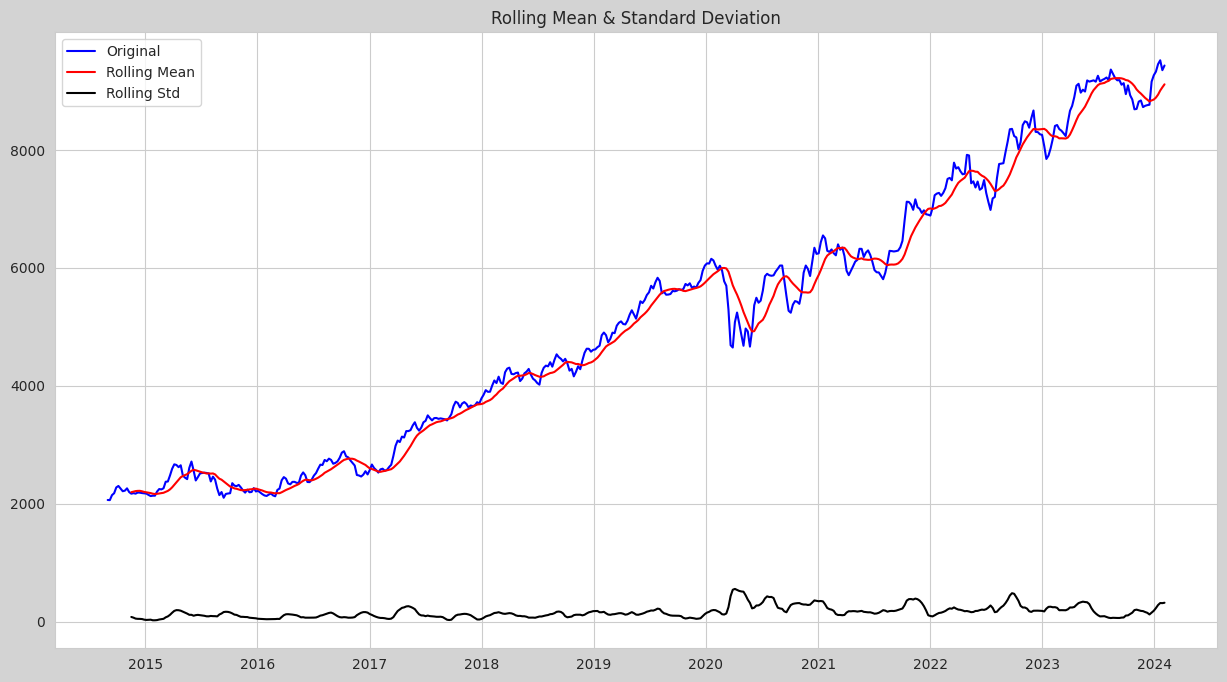

Results of Dickey-Fuller Test:
Test Statistic                   0.978618
p-value                          0.994035
#Lags Used                      17.000000
Number of Observations Used    475.000000
Critical Value (1%)             -3.444192
Critical Value (5%)             -2.867644
Critical Value (10%)            -2.570021
dtype: float64


In [28]:
test_stationarity(df2['Price_Seasonal_Adjusted'])

A **p-value** of **0.994035** from the Dickey-Fuller test strongly suggests that the differenced data is still not stationary. Let's explore the next data transformation methods.

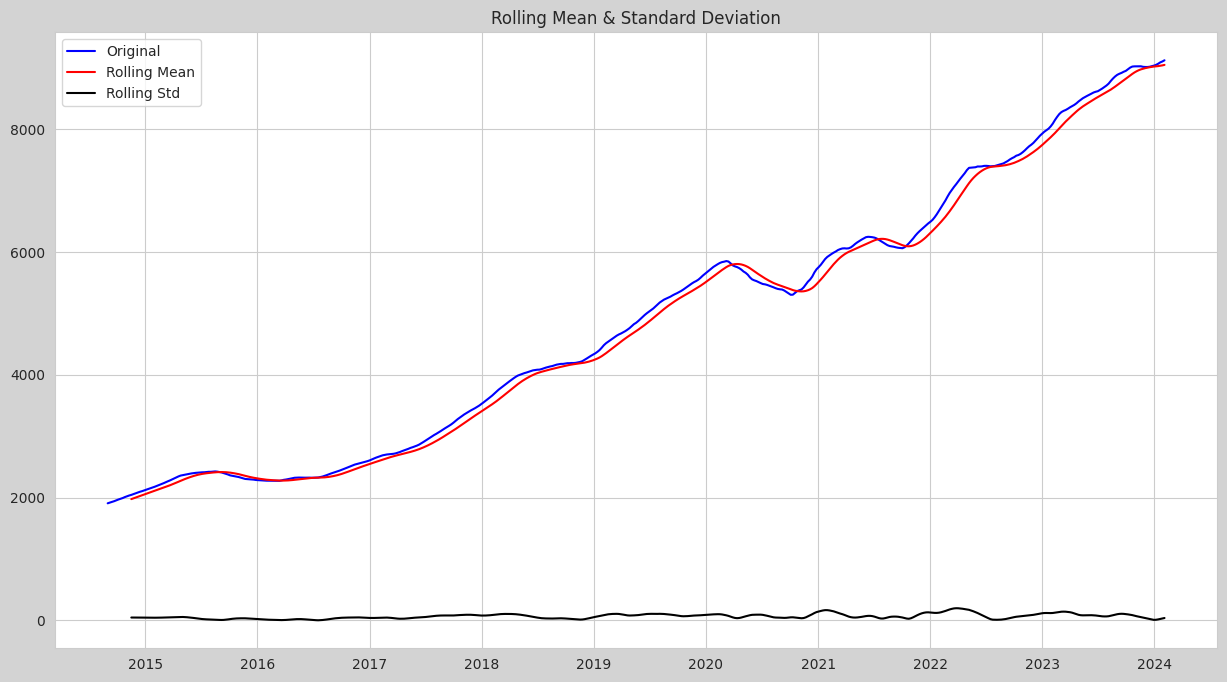

Results of Dickey-Fuller Test:
Test Statistic                   1.455138
p-value                          0.997351
#Lags Used                      14.000000
Number of Observations Used    478.000000
Critical Value (1%)             -3.444105
Critical Value (5%)             -2.867606
Critical Value (10%)            -2.570001
dtype: float64


In [29]:
test_stationarity(df2['Price_Rolling_Mean'])

A **p-value** of **0.997351** from the Dickey-Fuller test strongly suggests that the differenced data is still not stationary. Let's explore the next data transformation methods.

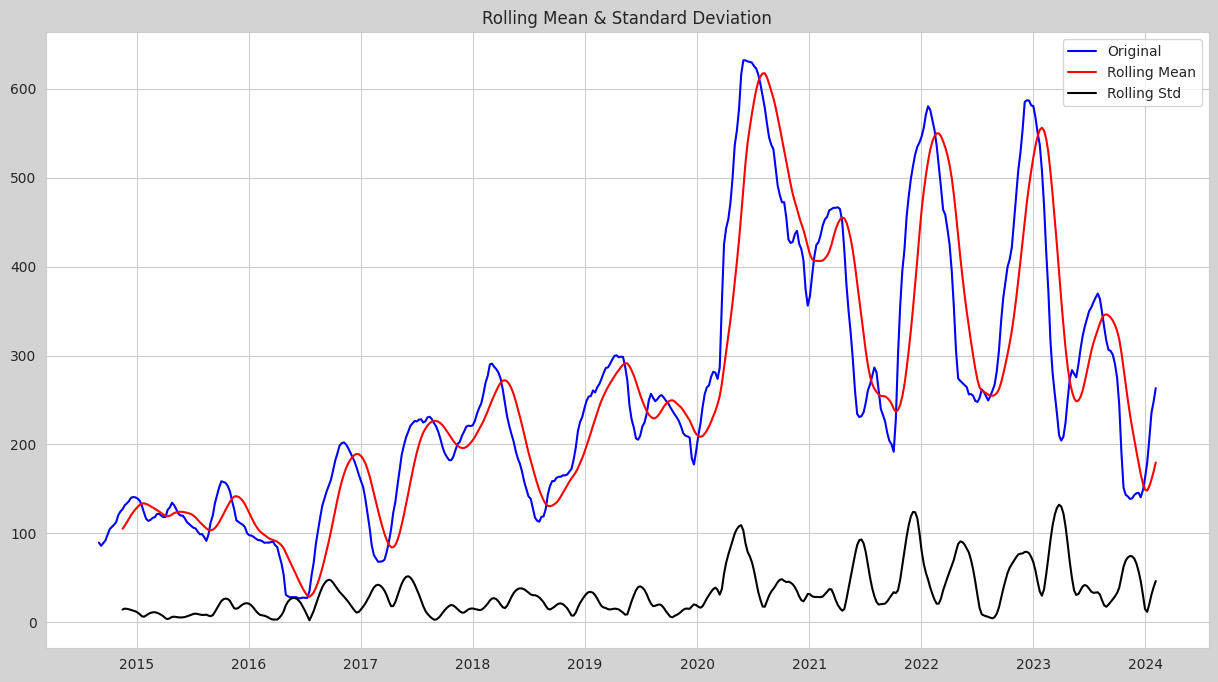

Results of Dickey-Fuller Test:
Test Statistic                  -3.672612
p-value                          0.004515
#Lags Used                       3.000000
Number of Observations Used    489.000000
Critical Value (1%)             -3.443794
Critical Value (5%)             -2.867469
Critical Value (10%)            -2.569928
dtype: float64


In [30]:
test_stationarity(df2['Price_Rolling_Std'])

A **p-value** of **0.004515** from the Dickey-Fuller test strongly suggests that the differenced data is stationary. This might be one of the candidate to feed in the model later.

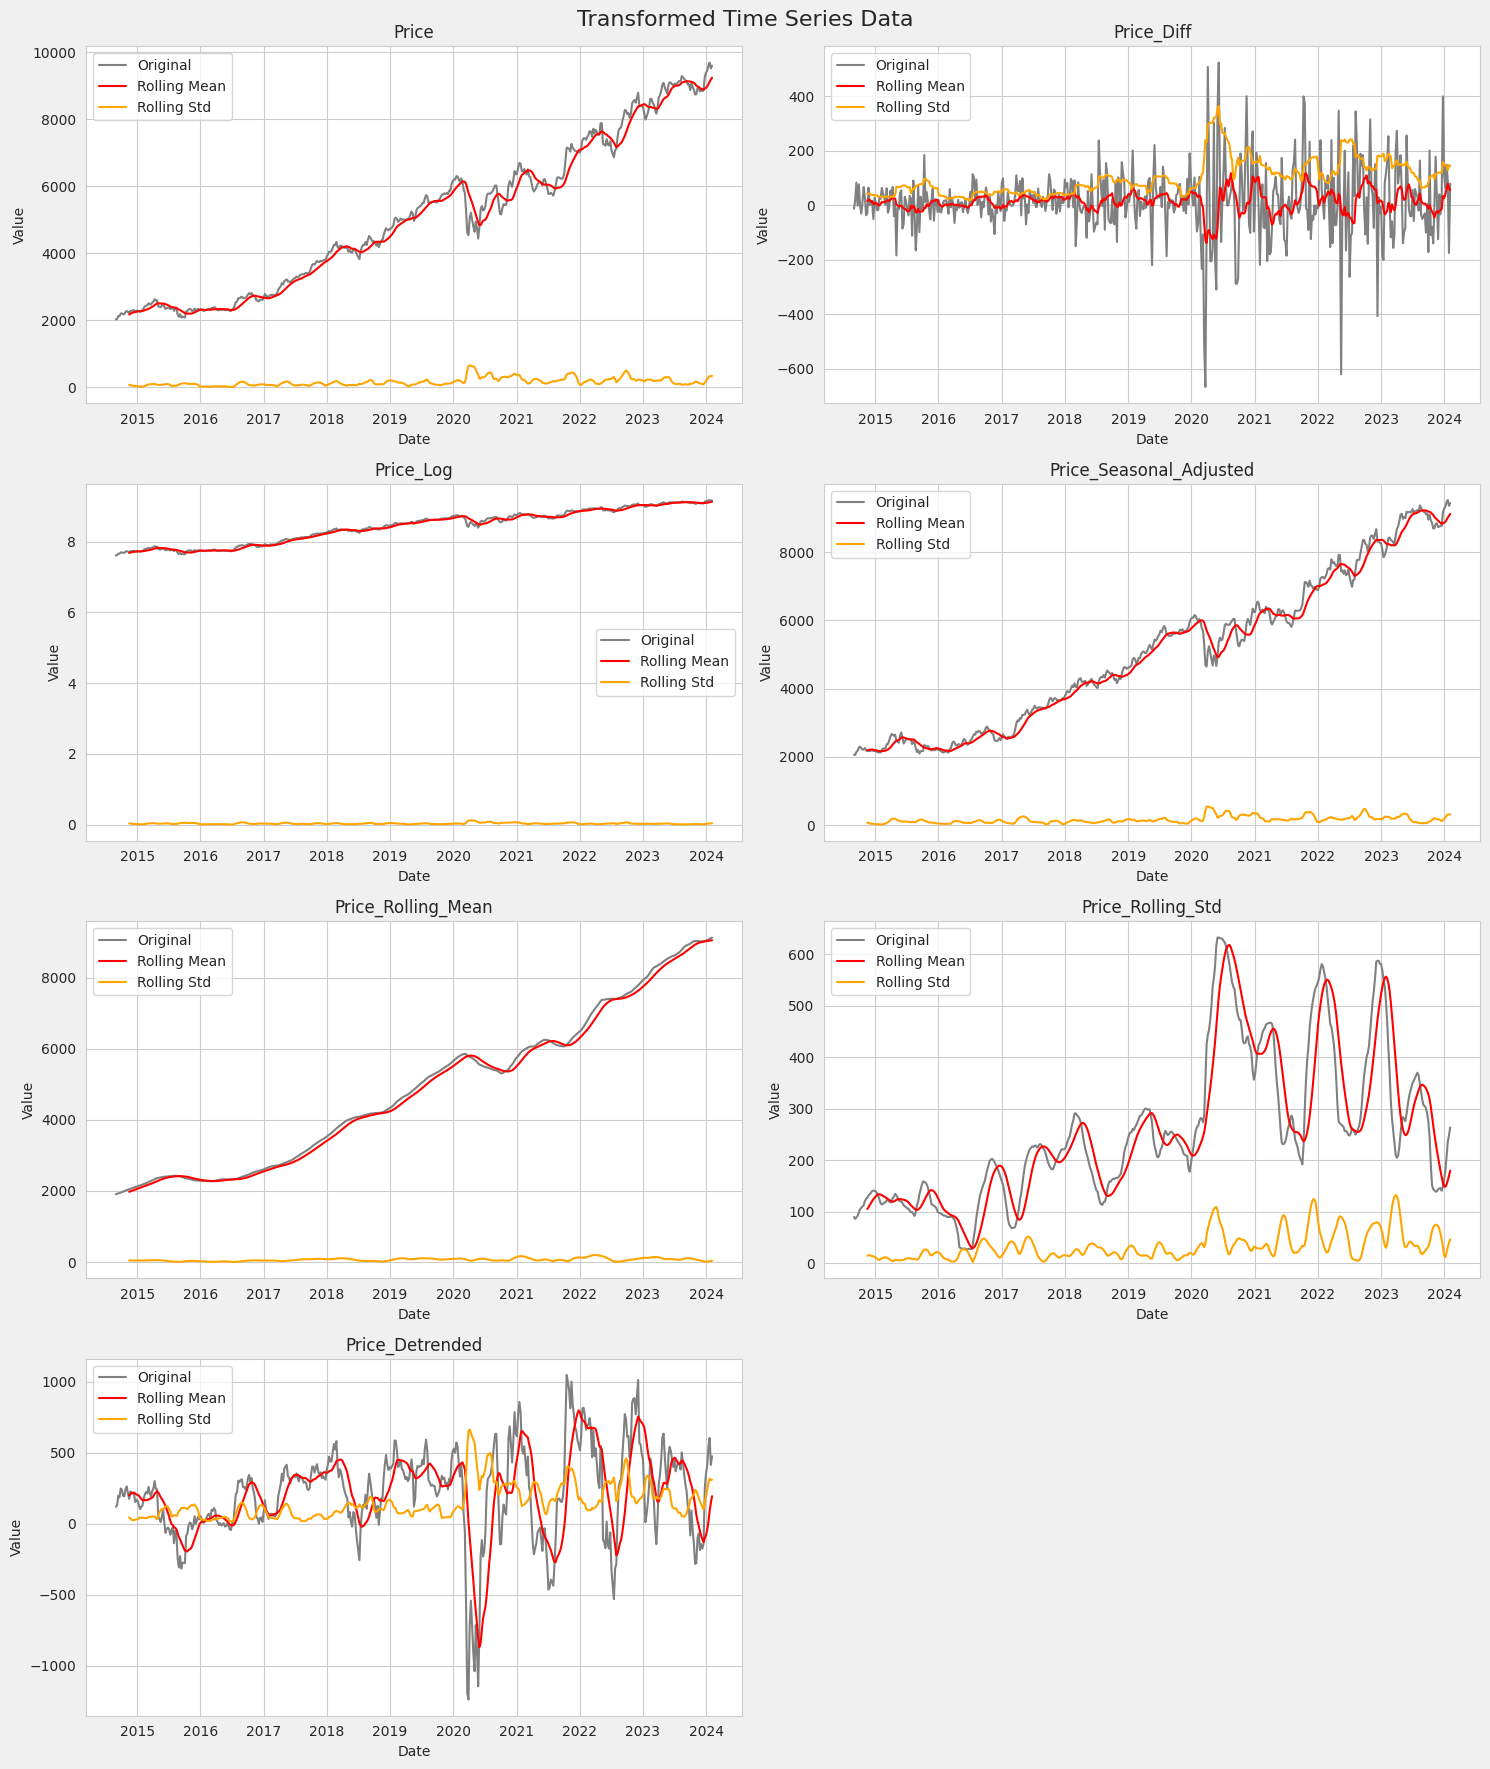

In [31]:
fig, axes = plt.subplots(4, 2, figsize=(15, 18), facecolor='#f0f0f0')

# Flatten the axes
axes = axes.flatten()

# List of columns to plot
columns_to_plot = ['Price', 'Price_Diff', 'Price_Log', 'Price_Seasonal_Adjusted', 'Price_Rolling_Mean', 'Price_Rolling_Std', 'Price_Detrended']

# Plot each column
for i, col in enumerate(columns_to_plot):
    ax = axes[i]
    ax.plot(df2.index, df2[col], label='Original', color='grey')

    # Calculate rolling statistics
    MA = df2[col].rolling(window=12).mean()
    MSTD = df2[col].rolling(window=12).std()

    ax.plot(df2.index, MA, color='red', label='Rolling Mean')
    ax.plot(df2.index, MSTD, color='orange', label='Rolling Std')

    ax.set_title(col)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()

# Hide any unused subplots
for i in range(len(columns_to_plot), 4 * 2):
    fig.delaxes(axes[i])

plt.suptitle("Transformed Time Series Data", size=16)
plt.tight_layout()
plt.show()

# **Build the Model 🤖**
---

In [32]:
# Let's use the transformed data for this model
Price = df2.Price_Detrended  # Adjust the chosen column as needed
Dates = df2.index

In [33]:
f = Forecaster(y=Price, current_dates=Dates)

f.set_test_length(0.25)
f.generate_future_dates(90) # Make the prediction for 90 days ahead

In [34]:
f

Forecaster(
    DateStartActuals=2014-08-31T00:00:00.000000000
    DateEndActuals=2024-02-04T00:00:00.000000000
    Freq=W-SUN
    N_actuals=493
    ForecastLength=90
    Xvars=[]
    TestLength=123
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

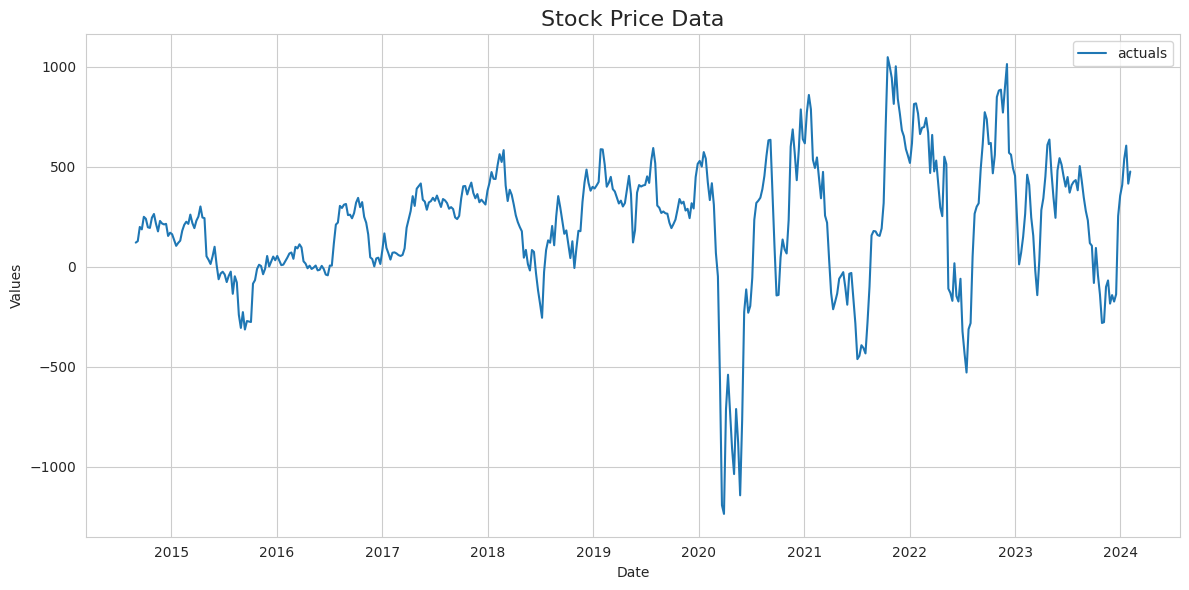

In [35]:
f.plot()
plt.title('Stock Price Data', size=16)
plt.tight_layout()
plt.show()

## **Exploratory Data Analysis with Scalecast 🗻**
---

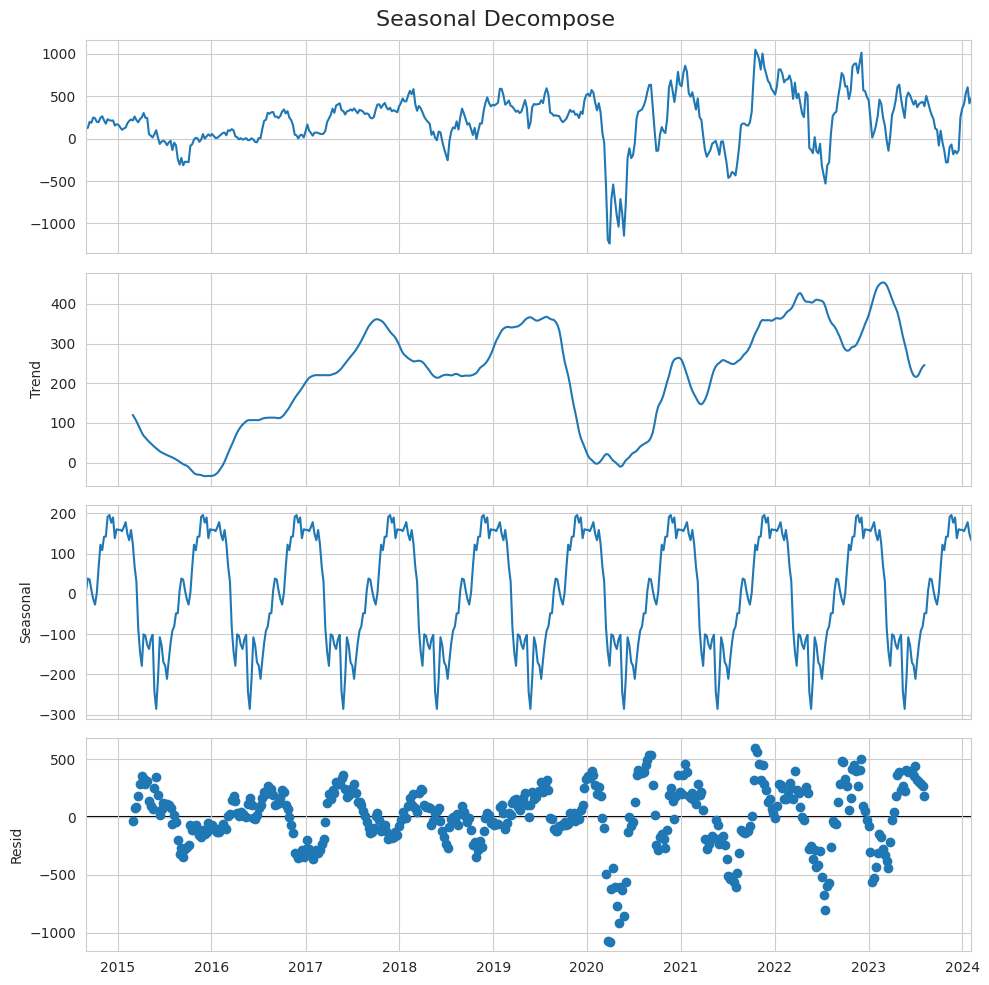

In [36]:
plt.rc("figure", figsize=(10,10))
f.seasonal_decompose().plot()
plt.suptitle('Seasonal Decompose', fontsize=16)
plt.tight_layout()
plt.show()

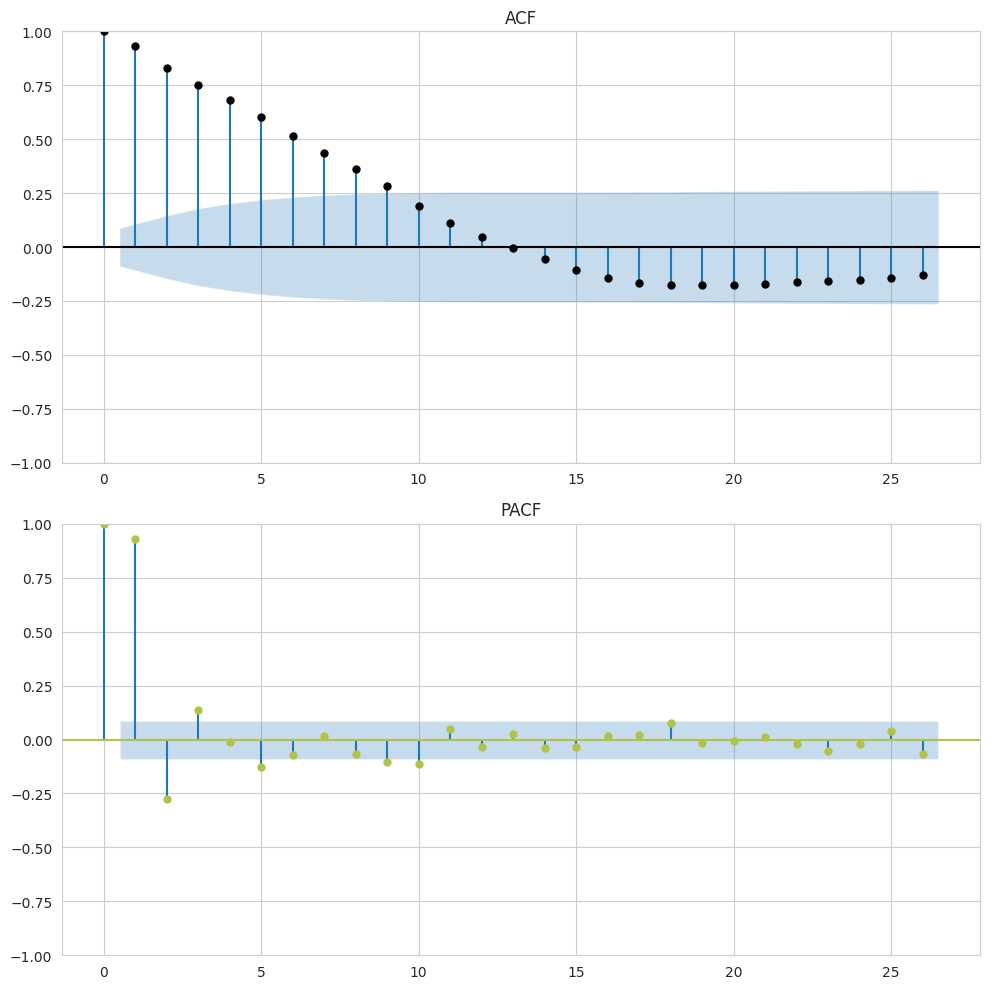

In [37]:
figs, axs = plt.subplots(2, 1, figsize=(10,10))
f.plot_acf(ax=axs[0], title='ACF', lags=26, color='black')
f.plot_pacf(ax=axs[1], title='PACF', lags=26, color='#B2C248', method='ywm')
plt.tight_layout()
plt.show()

## **LSTM**
---

2024-03-12 10:02:15.929903: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 10:02:15.930152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 10:02:16.139342: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


12/12 [==============================] - 0s 28ms/step


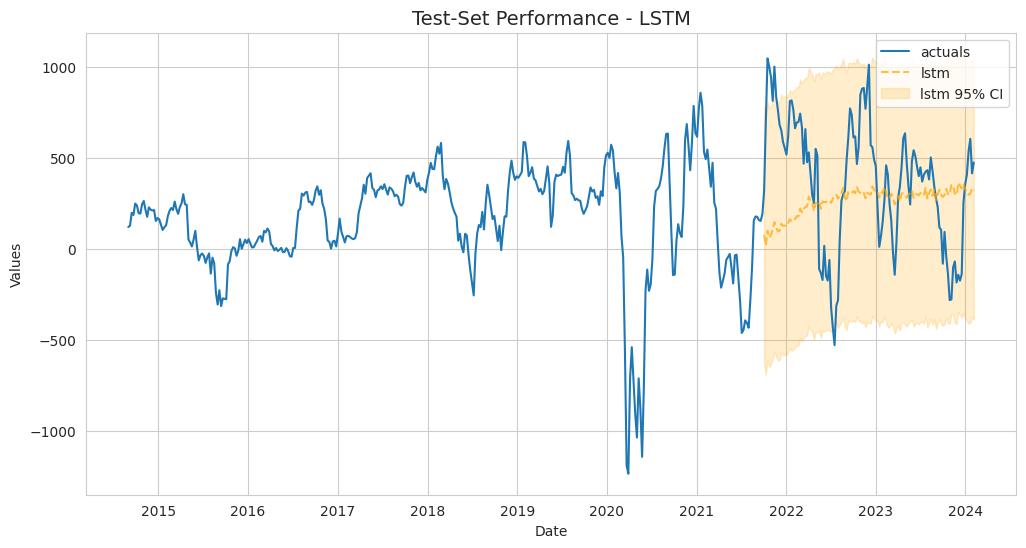

In [38]:
f.add_seasonal_regressors('week', raw=False, sincos=True)
f.set_estimator('lstm')
f.eval_cis(mode=True, cilevel=0.95)
f.manual_forecast(
    lags=36,
    batch_size=32,
    epochs=15,
    validation_split=.2,
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.001,
    lstm_layer_sizes=(100,)*3,
    dropout=(0,)*3,
    verbose=False
)

f.plot_test_set(models='lstm', ci=True)
plt.title('Test-Set Performance - LSTM', size=14)
plt.show()

# **Linear Scikit-Learn Models 📏**
---

## **MLR**
---

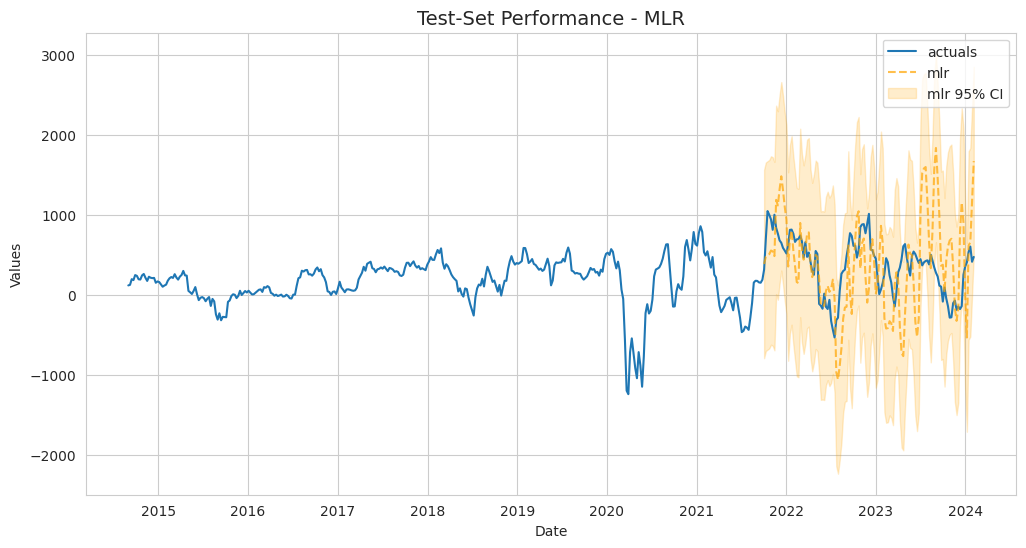

In [39]:
f.set_estimator('mlr') 
f.add_ar_terms(7) 
f.add_seasonal_regressors('month', 'quarter', dummy=True) 
f.add_seasonal_regressors('year') 
f.add_time_trend()
f.eval_cis(mode=True, cilevel=0.95)

f.manual_forecast(call_me='mlr', dynamic_testing=7)
f.plot_test_set(models='mlr', ci=True)
plt.title('Test-Set Performance - MLR', size=14)
plt.show()

## **Lasso**
---

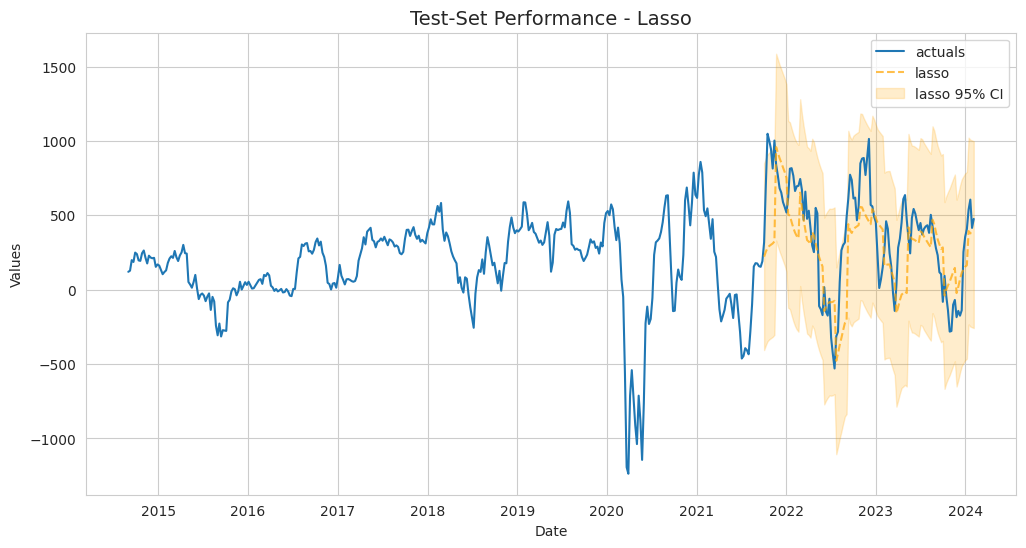

In [40]:
f.set_estimator('lasso') 
f.add_ar_terms(7) 
f.add_seasonal_regressors('month','quarter', dummy=True) 
f.add_time_trend()
f.eval_cis(mode=True, cilevel=0.95)

f.manual_forecast(call_me='lasso', dynamic_testing=7)
f.plot_test_set(models='lasso', ci=True)
plt.title('Test-Set Performance - Lasso', size=14)
plt.show()

## **Ridge**
---

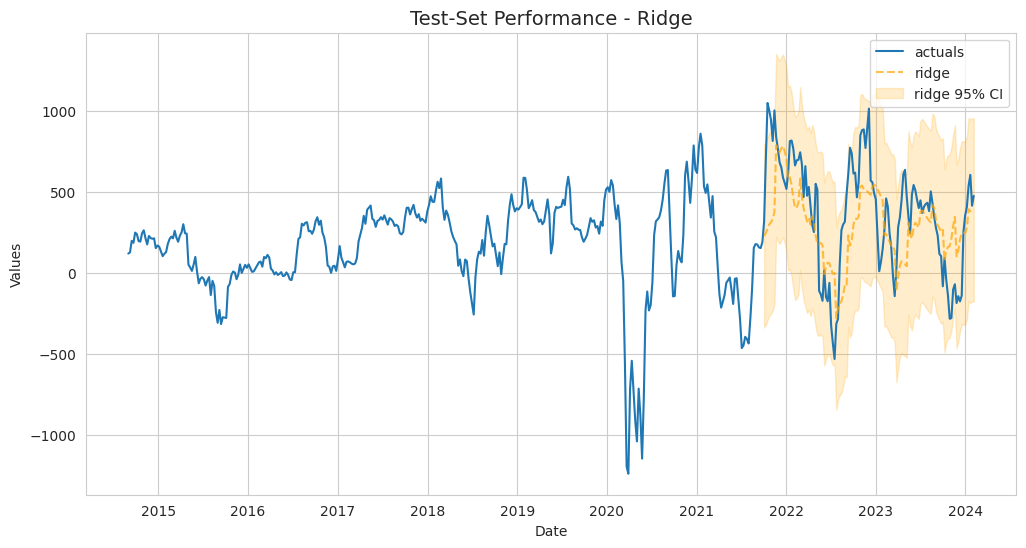

In [41]:
f.set_estimator('ridge') 
f.add_ar_terms(7) 
f.add_seasonal_regressors('month', 'quarter', dummy=True) 
f.add_time_trend()
f.eval_cis(mode=True, cilevel=0.95)

f.manual_forecast(call_me='ridge', dynamic_testing=7)
f.plot_test_set(models='ridge', ci=True)
plt.title('Test-Set Performance - Ridge', size=14)
plt.show()

## **Elasticnet**
---

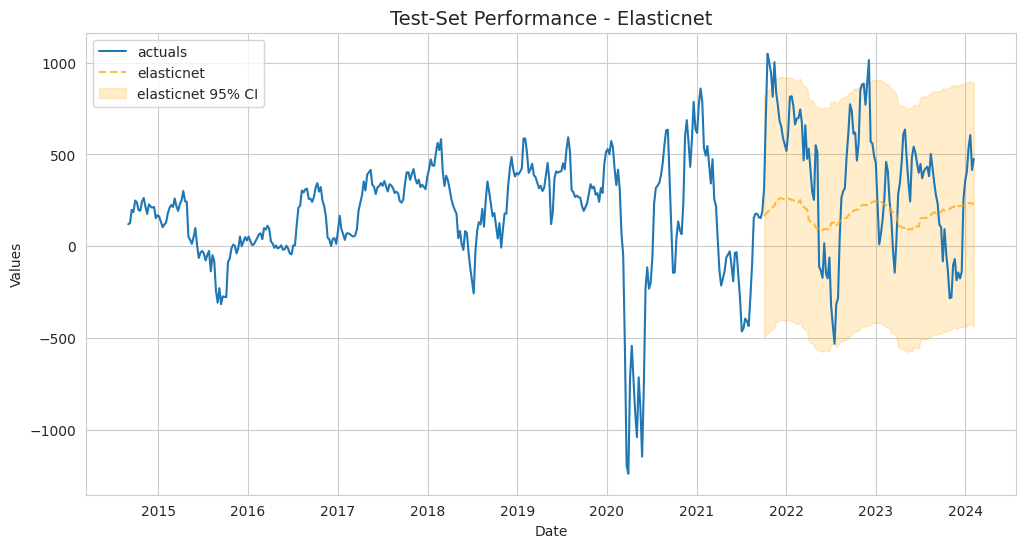

In [42]:
f.set_estimator('elasticnet') 
f.add_ar_terms(7) 
f.add_seasonal_regressors('month', 'quarter', dummy=True) 
f.add_time_trend()
f.eval_cis(mode=True, cilevel=0.95)

f.manual_forecast(call_me='elasticnet', dynamic_testing=7)
f.plot_test_set(models='elasticnet', ci=True)
plt.title('Test-Set Performance - Elasticnet', size=14)
plt.show()

## **SGD**
---

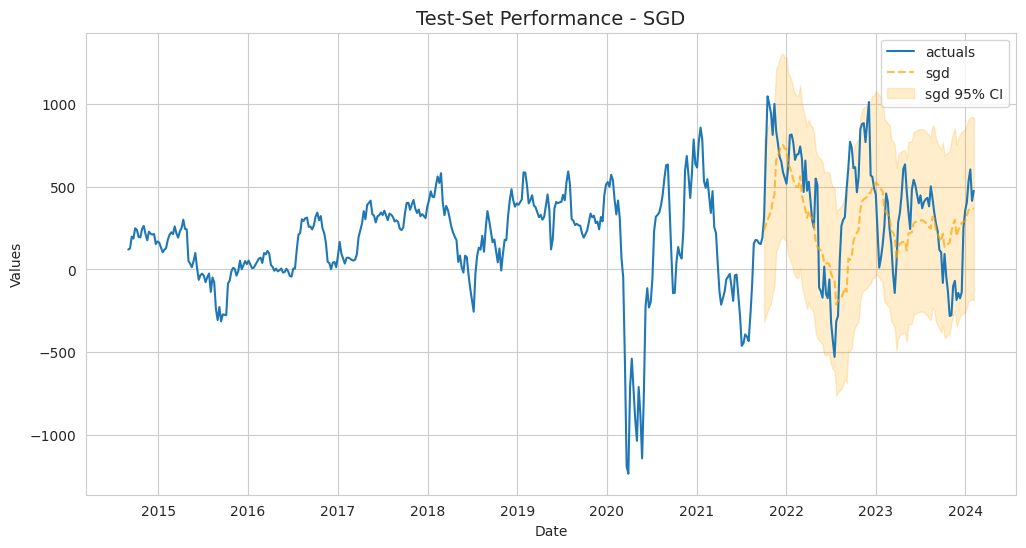

In [43]:
f.set_estimator('sgd') 
f.add_ar_terms(7) 
f.add_seasonal_regressors('month', 'quarter', dummy=True) 
f.add_time_trend()
f.eval_cis(mode=True, cilevel=0.95)

f.manual_forecast(call_me='sgd', dynamic_testing=7)
f.plot_test_set(models='sgd', ci=True)
plt.title('Test-Set Performance - SGD', size=14)
plt.show()

## **Model Evaluation & Prediction 📝**
---

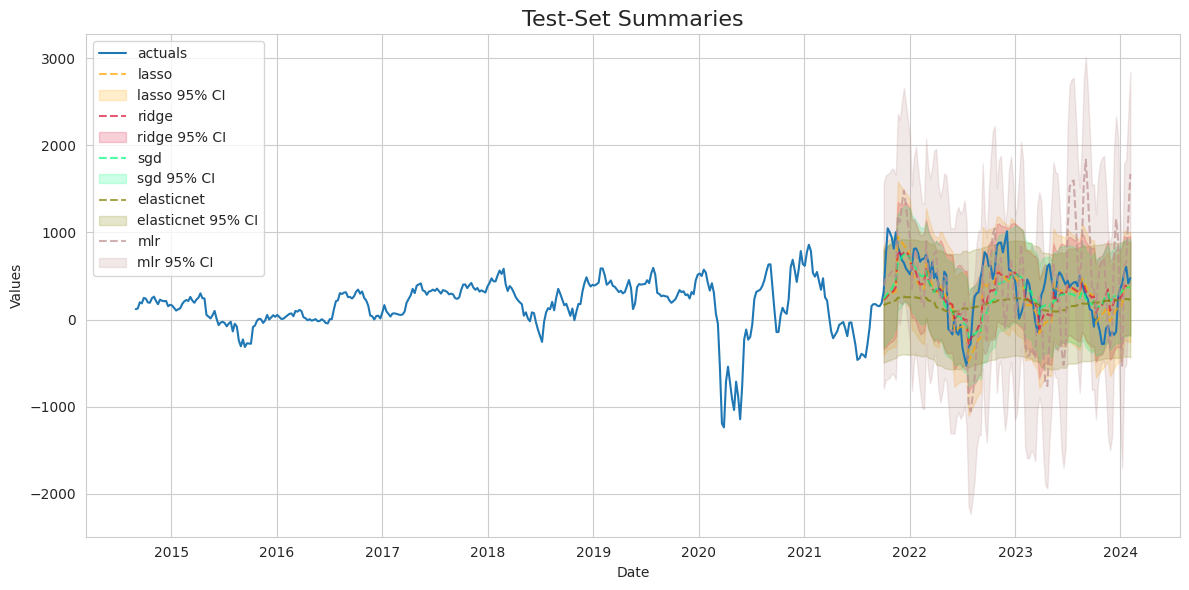

In [44]:
f.plot_test_set(ci=True, models=['mlr','lasso','ridge','elasticnet','sgd'], order_by='TestSetRMSE')
plt.title('Test-Set Summaries', fontsize=16)
plt.tight_layout()
plt.show()

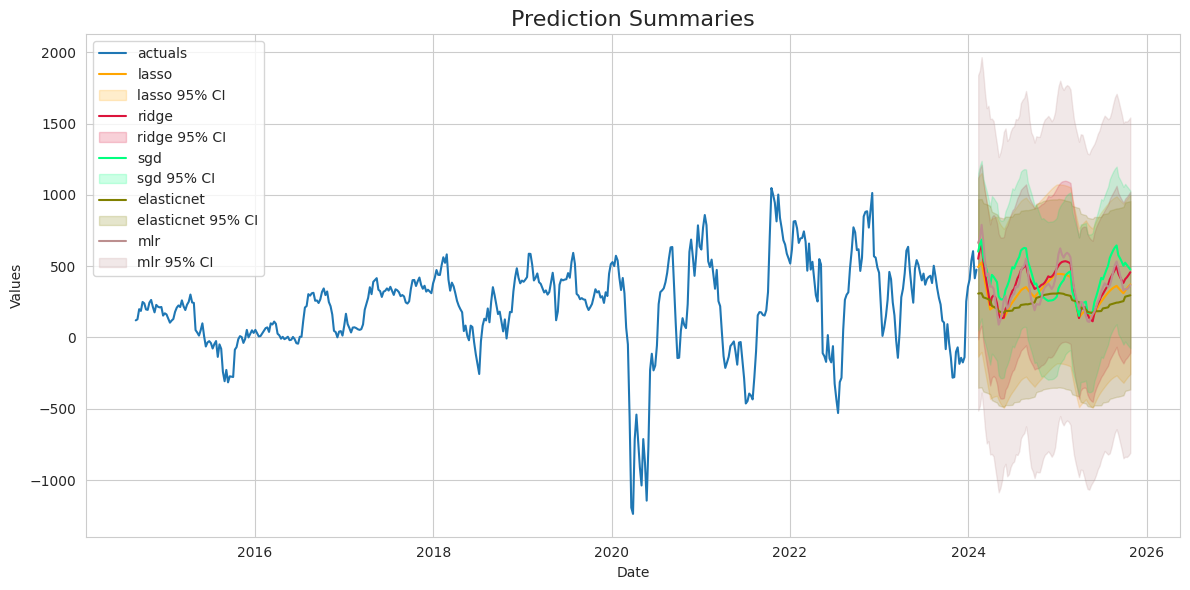

In [45]:
f.plot(ci=True, models=['mlr','lasso','ridge','elasticnet','sgd'], order_by='TestSetRMSE')
plt.title('Prediction Summaries', fontsize=16)
plt.tight_layout()
plt.show()

# **Non-linear Scikit-Learn Models 📐**
---

## **RF**
---

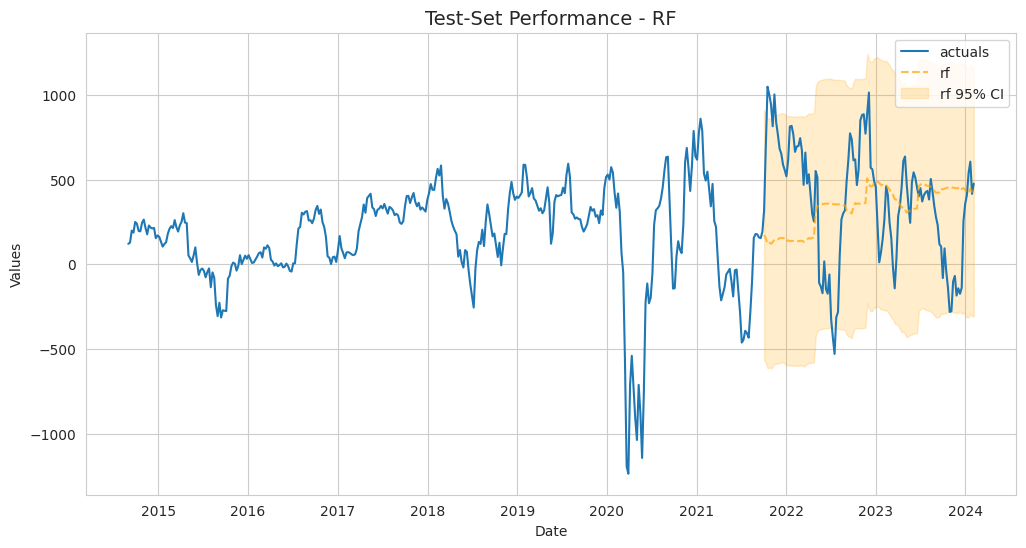

In [46]:
f.set_estimator('rf') 
f.add_ar_terms(30) 
f.add_seasonal_regressors('month', 'quarter', dummy=True) 
f.add_time_trend()
f.eval_cis(mode=True, cilevel=0.95)

f.manual_forecast(call_me='rf', dynamic_testing=30, max_depth=30)
f.plot_test_set(models='rf', ci=True)
plt.title('Test-Set Performance - RF', size=14)
plt.show()

## **GBT**
---

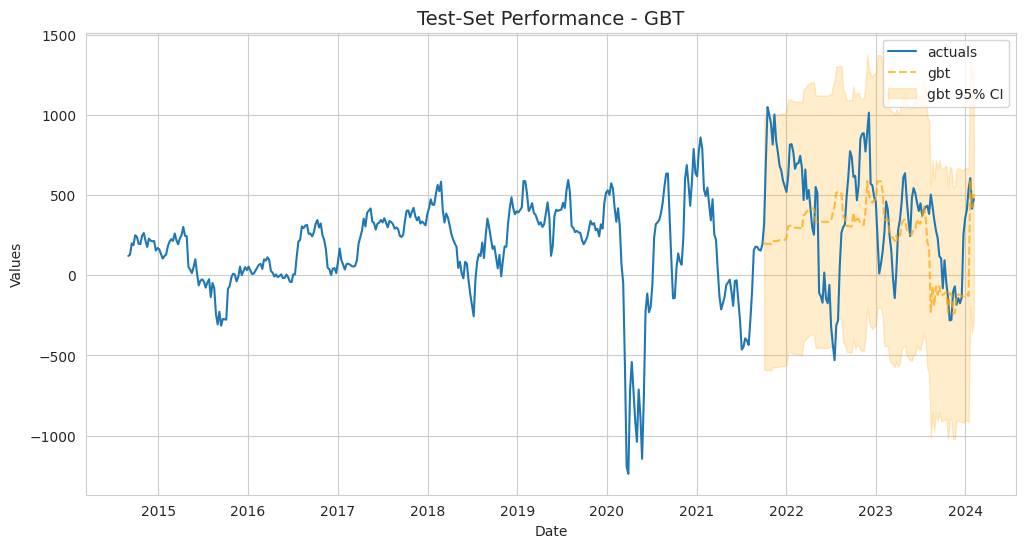

In [47]:
f.set_estimator('gbt') 
f.add_ar_terms(30) 
f.add_seasonal_regressors('month','quarter',dummy=True) 
f.add_time_trend()
f.eval_cis(mode=True, cilevel=0.95)

f.manual_forecast(call_me='gbt', dynamic_testing=30, max_depth=30)
f.plot_test_set(models='gbt', ci=True)
plt.title('Test-Set Performance - GBT', size=14)
plt.show()

## **XGBoost**
---

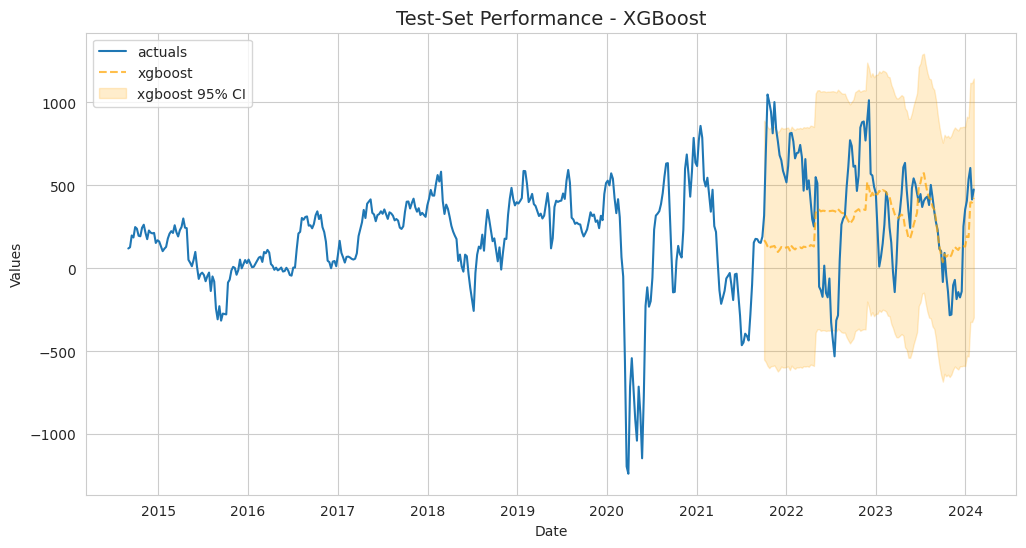

In [48]:
f.set_estimator('xgboost') 
f.add_ar_terms(30) 
f.add_seasonal_regressors('month', 'quarter', dummy=True) 
f.add_time_trend()
f.eval_cis(mode=True, cilevel=0.95)

f.manual_forecast(call_me='xgboost', dynamic_testing=30, gamma=1)
f.plot_test_set(models='xgboost', ci=True)
plt.title('Test-Set Performance - XGBoost', size=14)
plt.show()

## **LightGBM**
---

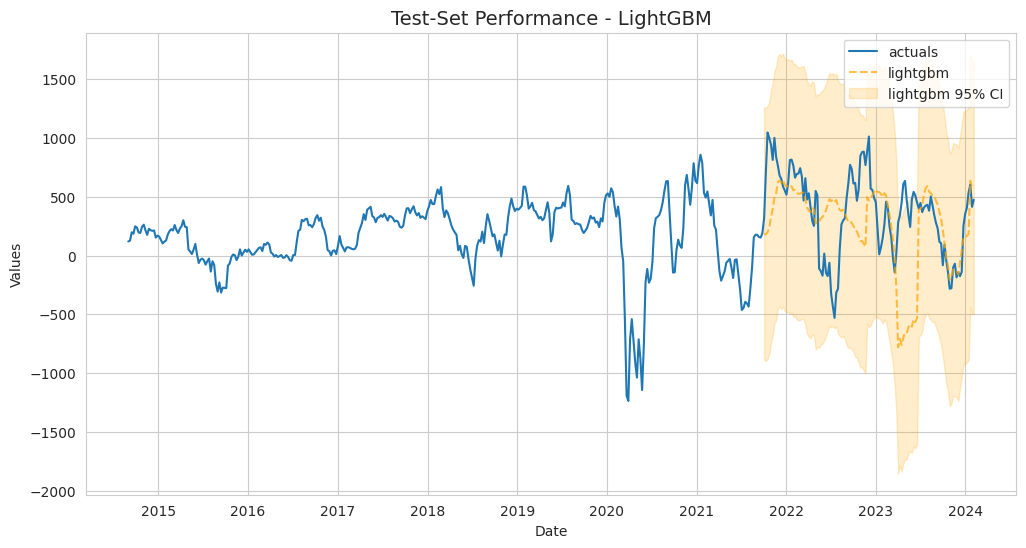

In [49]:
f.set_estimator('lightgbm') 
f.add_ar_terms(30) 
f.add_seasonal_regressors('month', 'quarter', dummy=True) 
f.add_time_trend()
f.eval_cis(mode=True, cilevel=0.95)

f.manual_forecast(call_me='lightgbm', dynamic_testing=30, max_depth=3, num_leaves=10, force_col_wise=True, verbose=-1)
f.plot_test_set(models='lightgbm', ci=True)
plt.title('Test-Set Performance - LightGBM', size=14)
plt.show()

## **CatBoost**
---

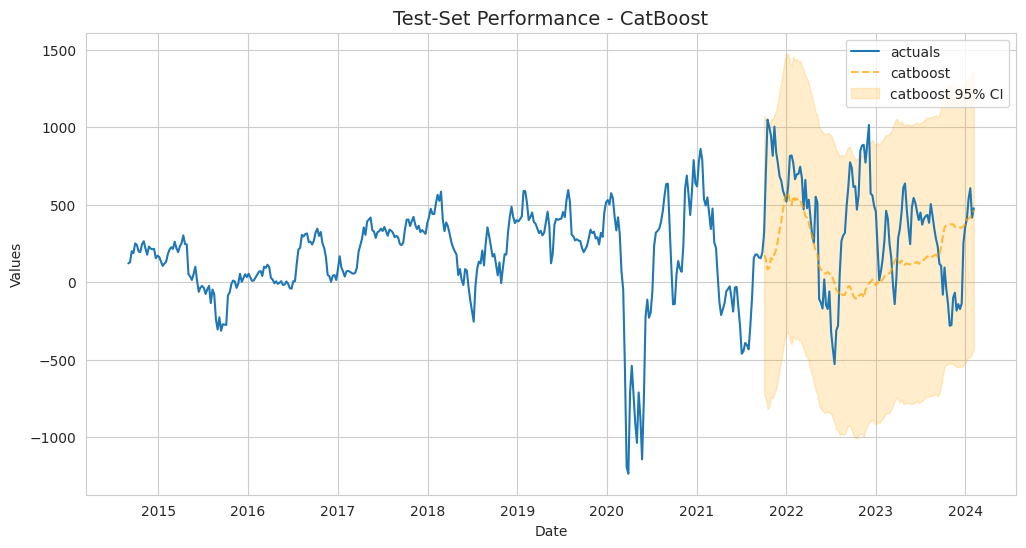

In [50]:
f.set_estimator('catboost')
f.add_ar_terms(30) 
f.add_seasonal_regressors('month', 'quarter', dummy=True) 
f.add_time_trend()
f.eval_cis(mode=True, cilevel=0.95)

f.manual_forecast(call_me='catboost', depth=4, verbose=False)
f.plot_test_set(models='catboost', ci=True)
plt.title('Test-Set Performance - CatBoost', size=14)
plt.show()

## **KNN**
---

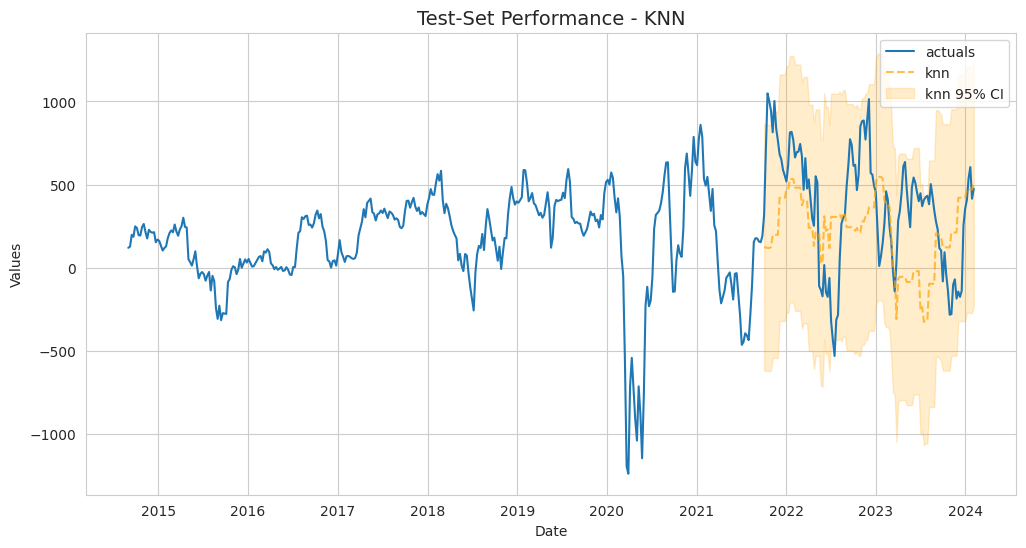

In [51]:
f.set_estimator('knn')
f.add_ar_terms(30) 
f.add_seasonal_regressors('month', 'quarter', dummy=True) 
f.add_time_trend()
f.eval_cis(mode=True, cilevel=0.95)

f.manual_forecast(call_me='knn', n_neighbors=5, dynamic_testing=30)
f.plot_test_set(models='knn', ci=True)
plt.title('Test-Set Performance - KNN', size=14)
plt.show()

## **MLP**
---

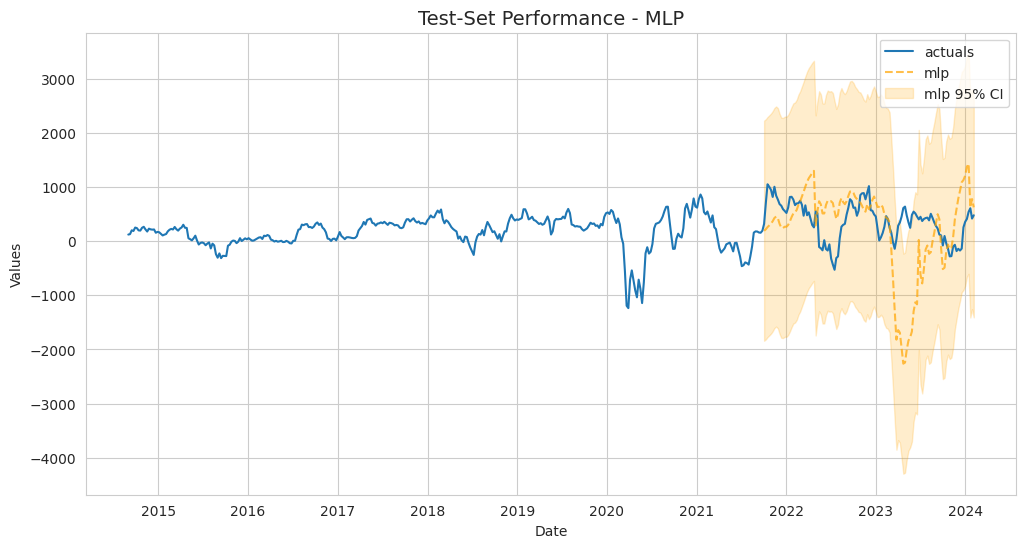

In [52]:
f.set_estimator('mlp')
f.add_ar_terms(30) 
f.add_seasonal_regressors('month', 'quarter', dummy=True) 
f.add_time_trend()
f.eval_cis(mode=True, cilevel=0.95)

f.manual_forecast(call_me='mlp', hidden_layer_sizes=(50,50), solver='lbfgs', dynamic_testing=30)
f.plot_test_set(models='mlp', ci=True)
plt.title('Test-Set Performance - MLP', size=14)
plt.show()

## **Model Evaluation & Prediction 📝**
---

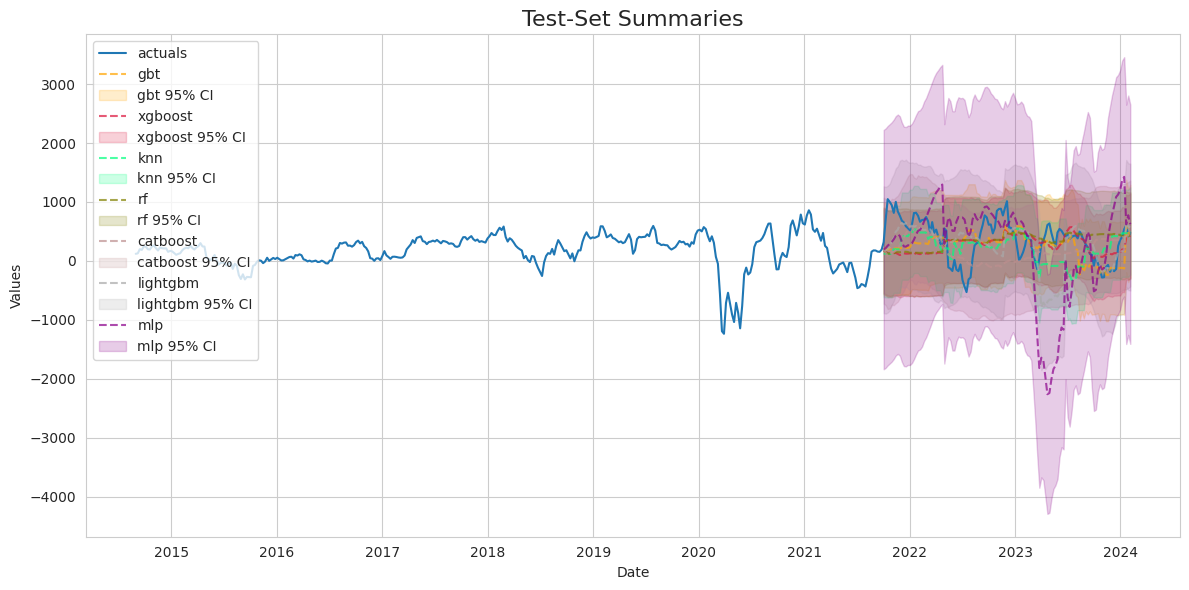

In [53]:
f.plot_test_set(
    ci=True,
    models=['rf','gbt','xgboost','lightgbm','catboost','knn','mlp'],
    order_by='TestSetRMSE'
)
plt.title('Test-Set Summaries', size=16)
plt.tight_layout()
plt.show()

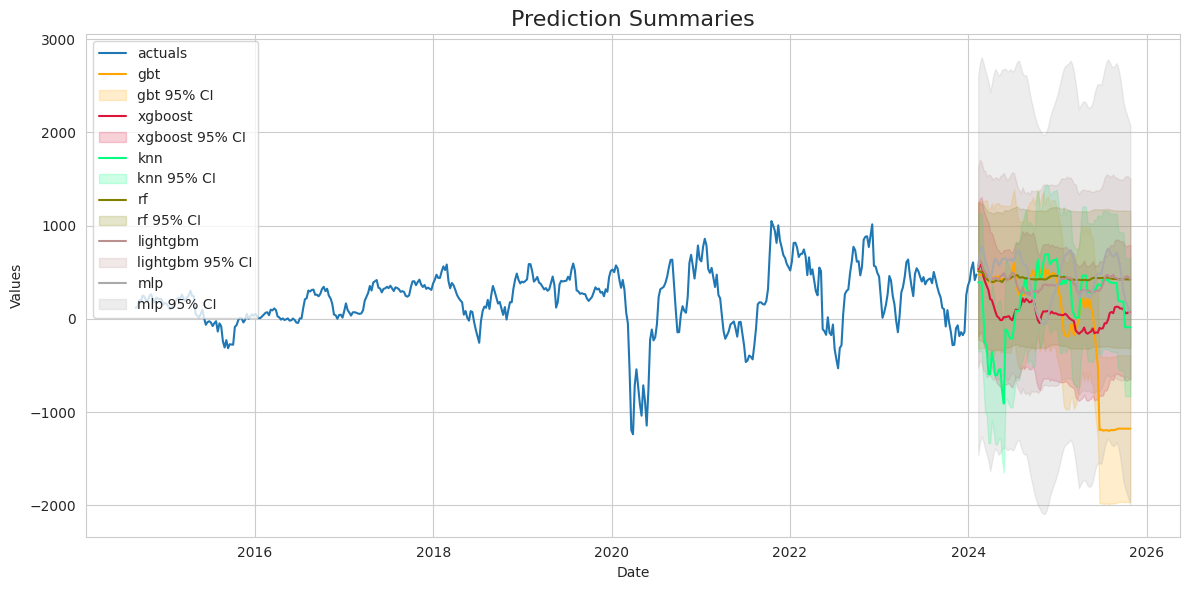

In [54]:
f.plot(ci=True,models=['rf','gbt','xgboost','lightgbm','knn','mlp'], order_by='TestSetRMSE')
plt.title('Prediction Summaries', size=16)
plt.tight_layout()
plt.show()

# **Explore Other Models 🛣️**
---

10:04:18 - cmdstanpy - INFO - Chain [1] start processing
10:04:18 - cmdstanpy - INFO - Chain [1] done processing
10:04:18 - cmdstanpy - INFO - Chain [1] start processing
10:04:18 - cmdstanpy - INFO - Chain [1] done processing


12/12 [==============================] - 0s 5ms/step


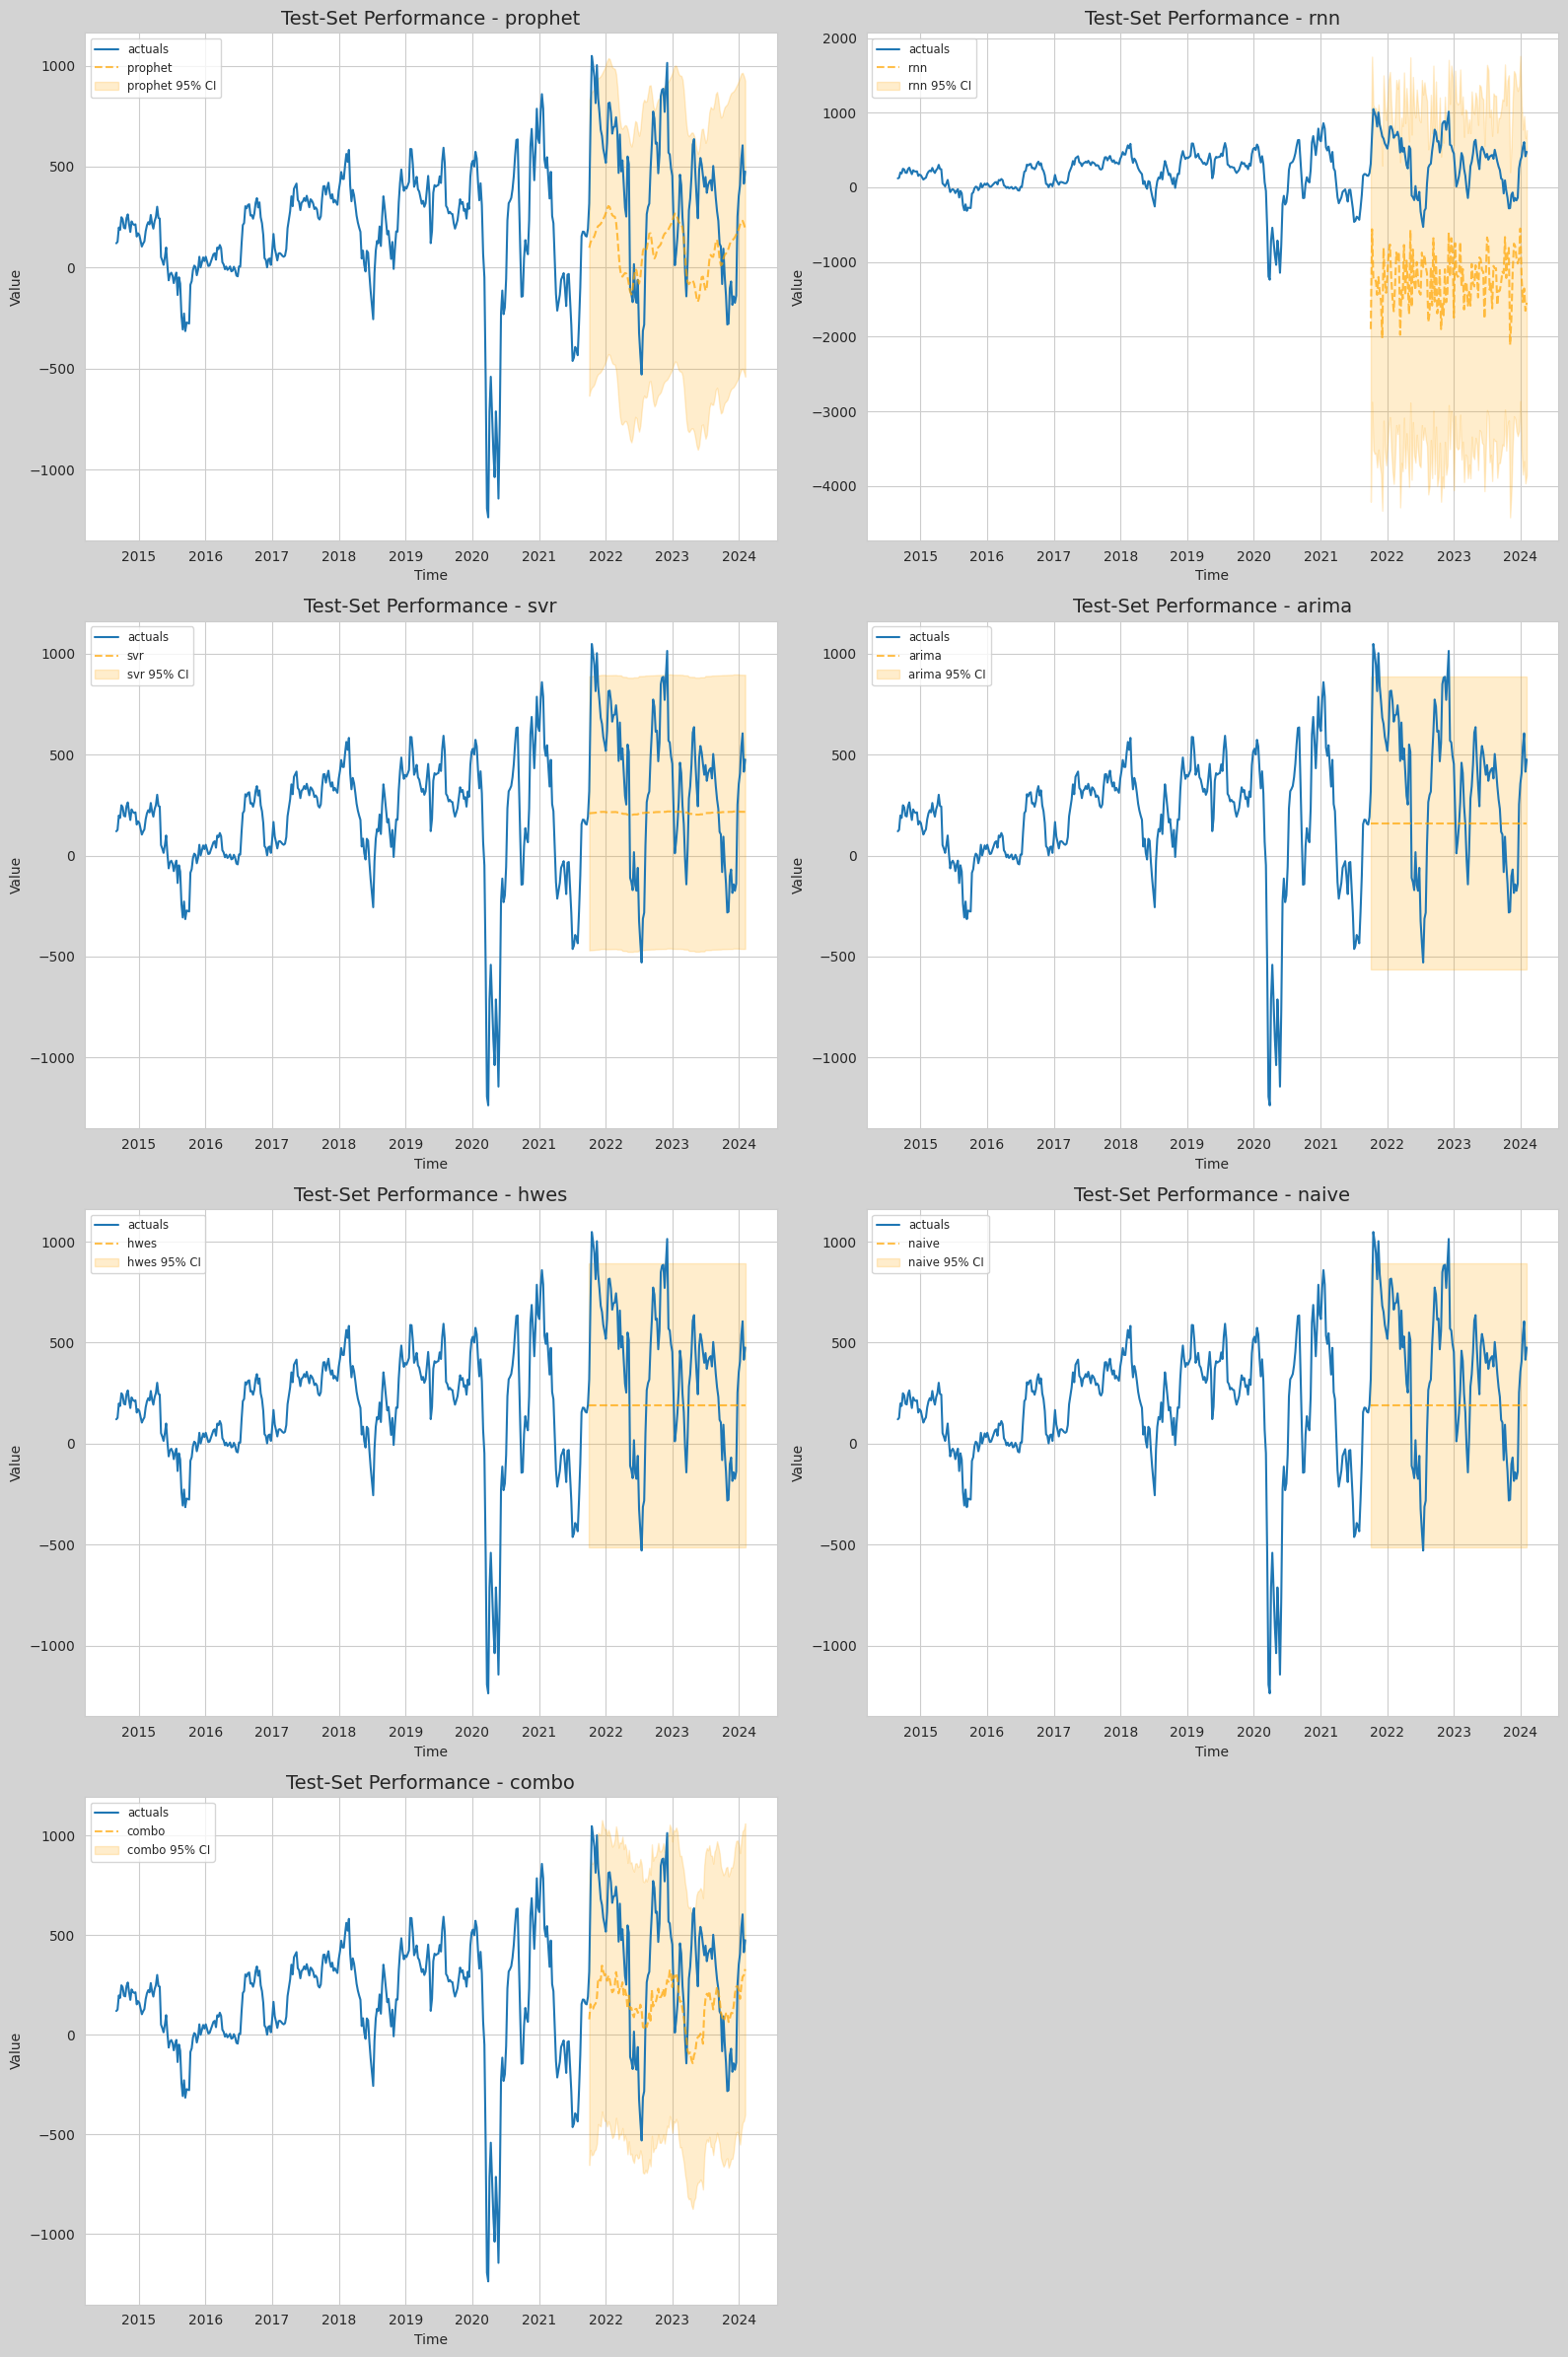

In [55]:
model_list = ['prophet','rnn','svr','arima','hwes','naive','combo']

num_rows = (len(model_list) + 1) // 2  # Number of rows needed for the subplot
fig, axs = plt.subplots(num_rows, 2, figsize=(16, 6 * num_rows))
fig.set_facecolor('lightgrey')

for i, model in enumerate(model_list):
    row = i // 2
    col = i % 2
    
    f.set_estimator(model)
    f.add_ar_terms(7) 
    f.add_seasonal_regressors('quarter', dummy=True) 
    f.add_time_trend()
    f.eval_cis(mode=True, cilevel=0.95)
    f.manual_forecast(call_me=model, dynamic_testing=True)
    f.plot_test_set(models=model, ci=True, include_train=True, ax=axs[row, col])
    
    axs[row, col].set_title(f'Test-Set Performance - {model}', size=14)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Value')
    axs[row, col].grid(True)
    axs[row, col].legend(loc='upper left', fontsize='small')

# If there are any remaining subplots, remove them
for i in range(len(model_list), num_rows * 2):
    row = i // 2
    col = i % 2
    fig.delaxes(axs[row, col])

plt.tight_layout()
plt.show()

# **Model Evaluation 📝**
---

In [56]:
results = f.export(dfs=['model_summaries','lvl_fcsts'], cis=True, to_excel=True)
model_summaries = results['model_summaries']
lvl_fcsts = results['lvl_fcsts'] 
ts_preds = f.export('lvl_test_set_predictions') 

In [57]:
model_eval = model_summaries[['ModelNickname','TestSetMAPE','TestSetRMSE','TestSetR2']].copy()

In [58]:
model_eval['Rank'] = model_eval['TestSetRMSE'].rank(ascending=True).astype(int)
model_eval.style.background_gradient(cmap='crest')

In [59]:
model_eval = model_eval.sort_values(by='Rank')
model_eval.style.background_gradient(cmap='viridis')

# **Make the Prediction 🔮**
---

In [60]:
# Filter the DataFrame based on rank
filtered_df = model_eval[model_eval['Rank'].between(1,5)]

# Extract the ModelNickname values as a list
best_model = filtered_df['ModelNickname'].tolist()
best_model

['lasso', 'ridge', 'sgd', 'gbt', 'elasticnet']

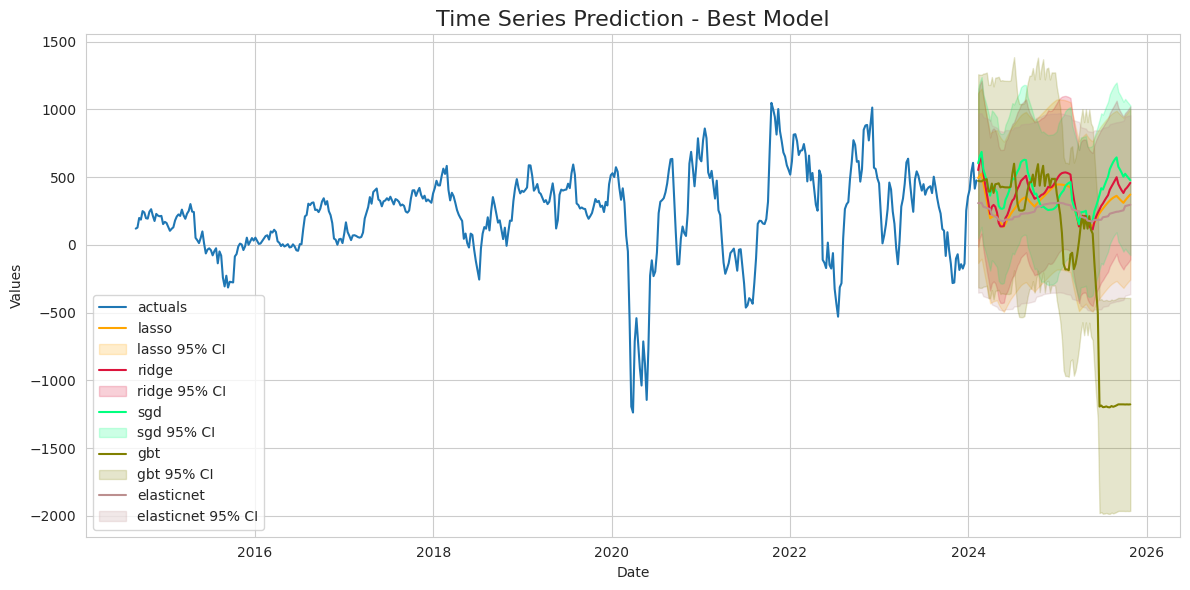

In [61]:
f.plot(models=best_model, order_by='TestSetR2', ci=True)
plt.title('Time Series Prediction - Best Model', size=16)
plt.tight_layout()
plt.show()

# **Model Stacking 📔**
---

In [62]:
f.add_sklearn_estimator(StackingRegressor, 'stacking')

In [63]:
estimators = [
    ('sgd', SGDRegressor()),
    ('ridge', Ridge(alpha=0.2)),
    ('mlr', Pipeline([
        ('scaler', StandardScaler()),
        ('linear_regression', LinearRegression())
    ]))
]

final_estimator = Lasso(alpha=0.2)

f.set_estimator('stacking')
f.manual_forecast(
    estimators=estimators,
    final_estimator=final_estimator,
    dynamic_testing=13,
    verbose=False
)

In [64]:
f.add_signals(['sgd','ridge','mlr','lasso'], train_only=True)
f.set_estimator('sgd')
f.manual_forecast(call_me = 'sgd_stack', verbose=False)

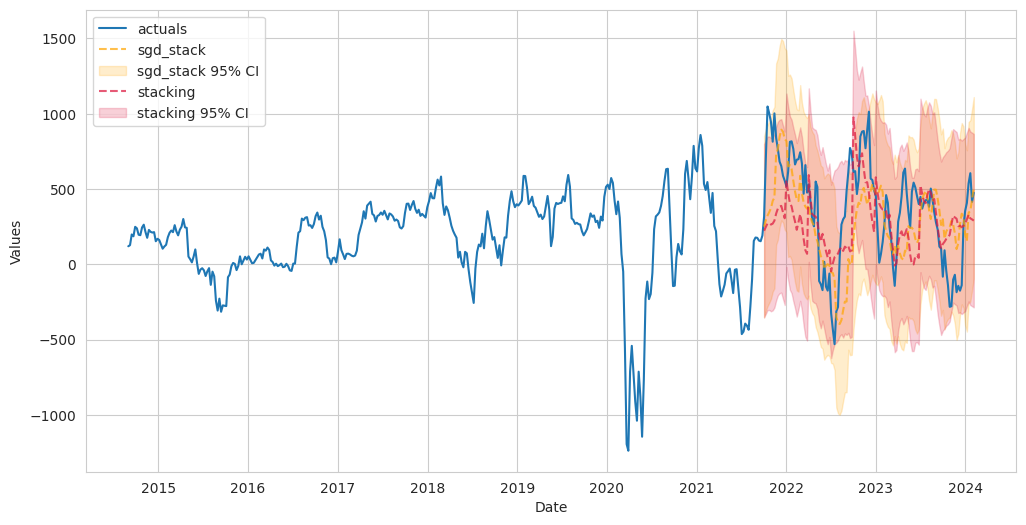

In [65]:
f.plot_test_set(models=['stacking','sgd_stack'], ci=True, order_by='TestSetRMSE')
plt.show()

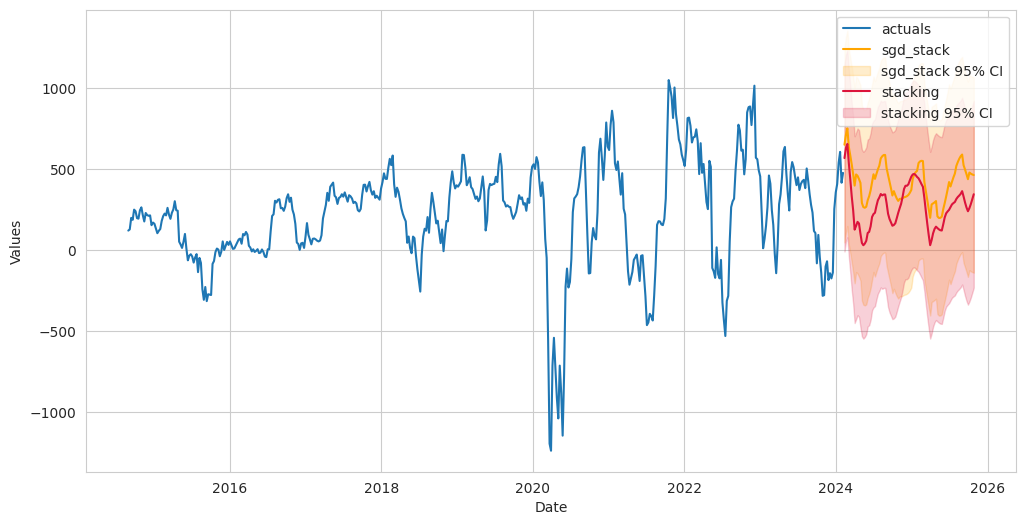

In [66]:
f.plot(models=['stacking','sgd_stack'], ci=True, order_by='TestSetRMSE')
plt.show()

In [67]:
stack_results = f.export(models=['stacking','sgd_stack'], cis=True, to_excel=True)
stack_model_summaries = stack_results['model_summaries']
stack_model_eval = stack_model_summaries[['ModelNickname','TestSetMAPE','TestSetRMSE','TestSetR2']].copy()
stack_model_eval['Rank'] = stack_model_eval['TestSetRMSE'].rank(ascending=True).astype(int)
stack_model_eval.style.background_gradient(cmap='crest')

In [68]:
predictions = f.export_Xvars_df(dropna=False)
df_predictions = pd.DataFrame(predictions)
df_predictions.tail().style.background_gradient(cmap='cividis')

/opt/conda/lib/python3.10/site-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/opt/conda/lib/python3.10/site-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


# **Analyze the Prediction Data 🎨**
---

In [69]:
ts_preds.tail().style.background_gradient(cmap='cividis')

In [70]:
lvl_fcsts.tail().style.background_gradient(cmap='cividis')

In [71]:
test_predictions = f.export_fitted_vals('lasso')
df_test_predictions = pd.DataFrame(test_predictions)
df_test_predictions.tail().style.background_gradient(cmap='cividis')

# **Visualize the Result and the Actual Data 🖼️**
---

In [72]:
# Add the rolling mean back to the detrended prices to obtain the original prices
df2['Price_Original'] = df2['Price_Detrended'] + rolling_mean

In [73]:
df3 = df2[['Price', 'Price_Detrended']].copy()
df3.head().style.background_gradient(cmap='cividis')

In [74]:
df3 = df3['2015-05-10':].resample('W', origin='start').mean()
df3['Price_Difference'] = df3.Price - df3.Price_Detrended
df3

Price  Price_Detrended  Price_Difference
Date                                                      
2015-05-10  2408.191406        34.430744       2373.760662
2015-05-17  2393.961364        13.288398       2380.672966
2015-05-24  2437.965527        51.137885       2386.827642
2015-05-31  2493.135107        99.382683       2393.752424
2015-06-07  2408.191528         9.132448       2399.059080
...                 ...              ...               ...
2024-01-07  9456.250000       407.824952       9048.425048
2024-01-14  9605.000000       538.135343       9066.864657
2024-01-21  9695.000000       605.368728       9089.631272
2024-01-28  9520.000000       415.343012       9104.656988
2024-02-04  9600.000000       475.743058       9124.256942

[457 rows x 3 columns]

In [75]:
merged_df = pd.merge(df3, df_test_predictions, left_index=True, right_on='DATE', how='inner')
merged_df = merged_df.rename(columns={'DATE': 'Date'})
merged_df = merged_df[['Date', 'Price', 'Price_Detrended', 'Price_Difference', 'Actuals', 'FittedVals', 'Residuals']]
merged_df

Date        Price  Price_Detrended  Price_Difference     Actuals  \
0   2015-05-10  2408.191406        34.430744       2373.760662   34.430744   
1   2015-05-17  2393.961364        13.288398       2380.672966   13.288398   
2   2015-05-24  2437.965527        51.137885       2386.827642   51.137885   
3   2015-05-31  2493.135107        99.382683       2393.752424   99.382683   
4   2015-06-07  2408.191528         9.132448       2399.059080    9.132448   
..         ...          ...              ...               ...         ...   
452 2024-01-07  9456.250000       407.824952       9048.425048  407.824952   
453 2024-01-14  9605.000000       538.135343       9066.864657  538.135343   
454 2024-01-21  9695.000000       605.368728       9089.631272  605.368728   
455 2024-01-28  9520.000000       415.343012       9104.656988  415.343012   
456 2024-02-04  9600.000000       475.743058       9124.256942  475.743058   

     FittedVals   Residuals  
0     28.314915    6.115829  
1      9.106078    4.182320  
2     -8.515410   59.653295  
3     27.313630   72.069053  
4    101.248636  -92.116188  
..          ...         ...  
452  391.696187   16.128765  
453  437.985536  100.149807  
454  546.678007   58.690721  
455  607.179702 -191.836689  
456  440.297989   35.445068  

[457 rows x 7 columns]

In [76]:
# Drop the 'Price' column
# merged_df = merged_df.drop(columns=['Final_Price'])

In [77]:
merged_df['Final_Price'] = merged_df.FittedVals + merged_df.Price_Difference
merged_df

Date        Price  Price_Detrended  Price_Difference     Actuals  \
0   2015-05-10  2408.191406        34.430744       2373.760662   34.430744   
1   2015-05-17  2393.961364        13.288398       2380.672966   13.288398   
2   2015-05-24  2437.965527        51.137885       2386.827642   51.137885   
3   2015-05-31  2493.135107        99.382683       2393.752424   99.382683   
4   2015-06-07  2408.191528         9.132448       2399.059080    9.132448   
..         ...          ...              ...               ...         ...   
452 2024-01-07  9456.250000       407.824952       9048.425048  407.824952   
453 2024-01-14  9605.000000       538.135343       9066.864657  538.135343   
454 2024-01-21  9695.000000       605.368728       9089.631272  605.368728   
455 2024-01-28  9520.000000       415.343012       9104.656988  415.343012   
456 2024-02-04  9600.000000       475.743058       9124.256942  475.743058   

     FittedVals   Residuals  Final_Price  
0     28.314915    6.115829  2402.075577  
1      9.106078    4.182320  2389.779044  
2     -8.515410   59.653295  2378.312233  
3     27.313630   72.069053  2421.066055  
4    101.248636  -92.116188  2500.307716  
..          ...         ...          ...  
452  391.696187   16.128765  9440.121235  
453  437.985536  100.149807  9504.850193  
454  546.678007   58.690721  9636.309279  
455  607.179702 -191.836689  9711.836689  
456  440.297989   35.445068  9564.554932  

[457 rows x 8 columns]

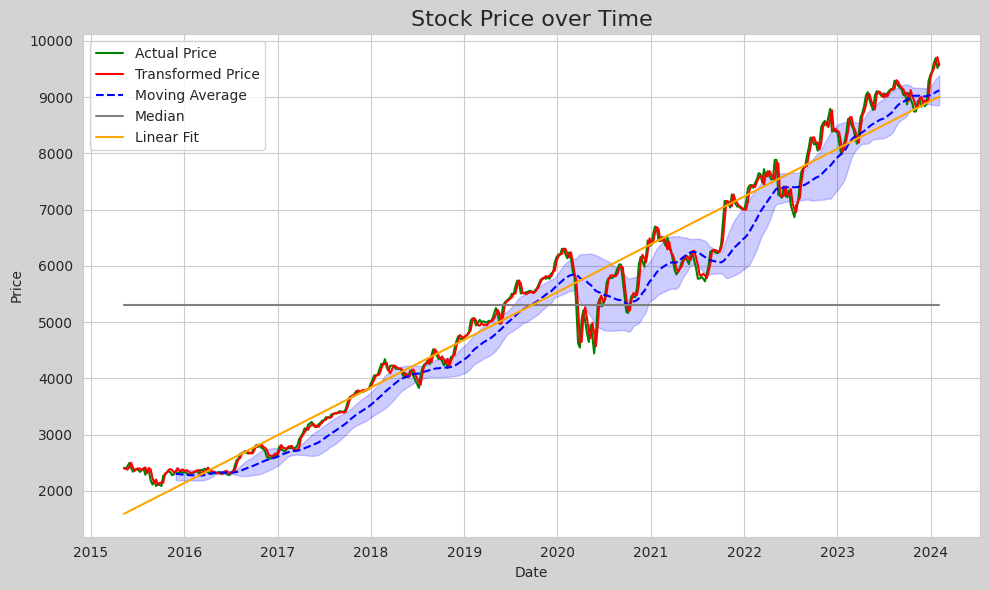

In [78]:
# Calculate Moving Average (MA) and Moving Standard Deviation (MSTD)
window_size = 30  # Adjust the window size as needed
merged_df['MA'] = merged_df['Price'].rolling(window=window_size).mean()
merged_df['MSTD'] = merged_df['Price'].rolling(window=window_size).std()

# Calculate median
median_price = merged_df['Price'].median()
median_line = [median_price] * len(merged_df)

# Calculate linear fit line
linear_fit = np.polyfit(merged_df['Date'].index, merged_df['Price'], 1)
linear_fit_line = np.polyval(linear_fit, merged_df['Date'].index)

# Plotting
plt.figure(figsize=(10, 6), facecolor='lightgrey')

plt.plot(merged_df['Date'], merged_df['Price'], linestyle='-', color='green', label='Actual Price')
plt.plot(merged_df['Date'], merged_df['Final_Price'], linestyle='-', color='red', label='Transformed Price')
plt.plot(merged_df['Date'], merged_df['MA'], linestyle='--', color='blue', label='Moving Average')
plt.fill_between(merged_df['Date'], merged_df['MA'] - merged_df['MSTD'], merged_df['MA'] + merged_df['MSTD'], color='blue', alpha=0.2)
plt.plot(merged_df['Date'], median_line, linestyle='-', color='grey', label='Median')
plt.plot(merged_df['Date'], linear_fit_line, linestyle='-', color='orange', label='Linear Fit')

plt.legend(loc='best')
plt.title('Stock Price over Time', size=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.tight_layout()
plt.show()

# **References 📃**
---
* [Bank Stock Price](https://www.kaggle.com/datasets/brmil07/bank-stock-price)
* [Time Series Forecasting](https://www.kaggle.com/code/brmil07/time-series-forecasting)
* [Scalecast Documentation](https://github.com/mikekeith52/scalecast)
* [Scalecast Introductory Example](https://scalecast-examples.readthedocs.io/en/latest/misc/introduction/Introduction2.html)
* [Scalecast Forecaster Object](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html)